## 1. Set-up
Install, import, helper functions, including dataloaders and processing functions.


### 1.1 installation

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.1 MB/s eta 0:00:00


In [ ]:
!pip install -q datasets albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 964.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.5 MB/s eta 0:00:00


Liveloss plot utility to watch train/validation loss in realtime

In [ ]:
!pip install livelossplot --quiet

In [ ]:
!pip install onedrivedownloader nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1.2 imports

In [ ]:
# imports

import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps
import random
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from datasets import load_dataset

from transformers import MaskFormerImageProcessor
from transformers import MaskFormerForInstanceSegmentation
import torchvision.transforms.functional as TF

import albumentations as A

from onedrivedownloader import download
import os
import nibabel as nib

# additional utils
from tqdm.auto import tqdm
from livelossplot import PlotLosses
# from google.colab import files

np.set_printoptions(precision=16)

### 1.3 environmental variables

In [ ]:
# create a data directory and set some variables
!mkdir data

DATA_DIR = 'data'
IMG_SEGM_DIR = os.path.join(DATA_DIR, "images_segm")
IMG_STRUCT_DIR = os.path.join(DATA_DIR, "images_structural")
IMG_REDUCED_DIR = os.path.join(DATA_DIR, "images_annot_reduced")
IMG_AUTO_SEGM_DIR = os.path.join(DATA_DIR, "automated_segm")
IMG_AUTO_SEGM_REDUCED_DIR = os.path.join(DATA_DIR, "automated_segm_reduced")

STRUCT_SCANS = ["T1", "T2", "T1GD", "FLAIR"]

In [ ]:
IMAGES_SEGM_URL = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EbmrLEe1ZgpNkaujtMtlDIEB9rQ0Zj82dOWIttA8sD5lSg"
IMAGES_SEGM_FNAME = "images_segm.zip"

IMAGES_STRUCTURAL_URL = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/ER8oOEAm1ANGlK4sodUPdX0B6_7IxmbRoneyo-RXI2HYOg"
IMAGES_STRUCTURAL_FNAME = "images_structural.zip"

IMAGES_ANNOT_REDUCED_URL = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EfqrvokObOJEhovsqLl_sscBgplo836OUdN5kJzAYqPZyg"
IMAGES_ANNOT_REDUCED_FNAME = "images_annot_reduced.zip"

IMAGES_AUTO_SEGM_URL = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EToY-Cli4vxMqYwHx_NZ4JsBi1Lo8tOskj9zb4_AZmDfcg"
IMAGES_AUTO_SEGM_FNAME = "automated_segm.zip"

IMAGES_AUTO_SEGM_REDUCED_URL = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EXwqKvC8QpBBjFQUXzKR1-IBtJeP1hwXUQAoJOneJx4-Hw"
IMAGES_AUTO_SEGM_REDUCED_FNAME = "automated_segm_reduced.zip"

### 1.4 General functions

In [ ]:
# helper functions

##
def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
    class_labels = [example["class_labels"] for example in batch]
    mask_labels = [example["mask_labels"] for example in batch]
    return {"pixel_values": pixel_values, "pixel_mask": pixel_mask, "class_labels": class_labels, "mask_labels": mask_labels}

## get mask
def get_mask(segmentation, segment_id):
  mask = (segmentation.cpu().numpy() == segment_id)
  visual_mask = (mask * 255).astype(np.uint8)
  visual_mask = Image.fromarray(visual_mask)
  return visual_mask

def split_subjects(input_list, split_ratio=0.8, seed=0):
    random.seed(seed)

    # get the number of indice for output files
    n_data = len(input_list)
    n1 = round(n_data*split_ratio)
    n2 = n_data - n1

    # get the list of indice for output files
    output_list_1 = random.sample(input_list, n1)
    output_list_2 = [data for data in input_list if data not in output_list_1]

    return output_list_1, output_list_2


## randomly split data (index file) based on given ratio
def split_data_index(input_fn, output_fn_1, output_fn_2, split_ratio=0.8, seed=0):
    random.seed(seed)

    index_in = []
    # get the list of index from file
    with open(input_fn, 'r') as file:
        for line in file:
            index_in.append(line.strip())

    # get the number of indice for output files
    n_data = len(index_in)
    n1 = round(n_data*split_ratio)
    n2 = n_data - n1

    # get the list of indice for output files
    index_out_1 = random.sample(index_in, n1)
    index_out_2 = [idx for idx in index_in if idx not in index_out_1]

    # write output files
    with open(output_fn_1, 'w') as file:
        for item in index_out_1:
            file.write("%d\n" % int(item))

    with open(output_fn_2, 'w') as file:
        for item in index_out_2:
            file.write("%d\n" % int(item))

## calculate mIoU
def compuate_mIoU(mask_pred, mask_true):
    num_i = len( np.where(mask_pred * mask_true != 0)[0] )
    num_u = len( np.where(mask_pred + mask_true != 0)[0] )
    mIoU = num_i / num_u * 100
    return mIoU, num_u

## define how to load individual data
def obtain_data(dir, index_list, index, convert_rgb=False):

    data_exact = {}

    with open(dir+'/'+index_list, 'r') as file:
        num_lines = sum(1 for line in file)

    if index >= num_lines:
        print("warning: given index",index,"does not exist in data. Try different index.")
        return None

    with open(dir+'/'+index_list, 'r') as file:
        for line_number, line_content in enumerate(file):
            if line_number == index:
                file_no = str(line_content).strip()

    if convert_rgb:
      data_exact['image'] = Image.open(dir+"/image"+file_no+".jpg").convert("RGB")
    else:
      data_exact['image']       = Image.open(dir+"/image"+file_no+".jpg")
    data_exact['image']       = ImageOps.exif_transpose(data_exact['image']) # handle rotation correctly
    data_exact['annotation']  = Image.open(dir+"/annot"+file_no+".png")
    data_exact['index2label'] = torch.load(dir+"/index2label"+file_no+".pt")

    return data_exact


### Display functions

In [ ]:
def get_img_path(subj_file, struct_scan=None, segm=False, auto_segm=False, reduced=False):
  '''
    Description: Constructs the file name and directory for the image file depending on supplied parameters
    Args:
        struct_scan: specify type of scan to be loaded: T1, T2, T1GD, FLAIR
        segm: If true, load the manually annotated image. if struct_scan is not None, this will be overriden
              and the structural image will be loaded instead
        auto_segm: If true, load the auto-labeled segmented image
        reduced: If true, load the reduced version of the specified image type. This parameter can be true for any image

    Returns: file name and file path
  '''
  # assert that struct_scan should be specified if we are not loading the labelled/segmented images
  if segm == False and auto_segm == False:
    assert struct_scan is not None, f'Specify which struct scan {STRUCT_SCANS} if both segm and auto_segm is False'

  # assert that image cannot be both manual and auto-labelled
  if segm == True and auto_segm == True:
    assert auto_segm == False, 'Can only select either segmented or auto-segmented'

  f_name = f"{subj_file}"
  f_dir = ""

  # build file name and supply the file path based on current onedrive folder structure
  if struct_scan is not None:
    f_name = f"{f_name}_{struct_scan}"
    f_dir = os.path.join(IMG_STRUCT_DIR, subj_file)

  if segm:
    f_name = f"{f_name}_segm"
    f_dir = IMG_SEGM_DIR

  if auto_segm:
    f_name = f"{f_name}_automated_approx_segm"
    f_dir = IMG_AUTO_SEGM_DIR

  if reduced:
    f_name = f"{f_name}_cut"
    f_dir = IMG_AUTO_SEGM_REDUCED_DIR if auto_segm==True else IMG_REDUCED_DIR

  f_name = f"{f_name}.nii.gz"
  f_path = os.path.join(f_dir, f_name)
  return f_name, f_path

def load_nifti_img(subj_file, struct_scan=None, segm=False, auto_segm=False, reduced=False, dtype=None):
    '''
      Args:
        subj_file: e.g. UPENN-GBM-00001_11
        struct_scan: T1, T2, T1GD, FLAIR
        dtype: e.g. uint. default is float64 if none is supplied

      Description: Loads nifti file depending on supplied parameters
      Returns: file name and loaded image
    '''
    f_name, f_path = get_img_path(subj_file, struct_scan=struct_scan, segm=segm, auto_segm=auto_segm, reduced=reduced)
    nifti = nib.load(f_path)
    img_data = None

    if dtype is not None:
      img_data = nifti.get_fdata().astype(dtype)
    else:
      img_data = nifti.get_fdata()
    return f_name, img_data

def plot_struct_img(img_data, fig, axs, row, col, title=None, cmap="Greys_r", auto_cbar=True, alpha_mask=None):
    '''
      Args:
        img_data: loaded nifti file
        auto_bar: add the color bar if true

      Returns: Plotted image
    '''

    # TODO: add slice idx as parameter. For now, use the slice with the largest tumor
    nonzero_counts = np.sum(np.count_nonzero(img_data, axis=0), axis=0 )
    slice_idx = np.argmax(nonzero_counts)

    alpha = None
    if alpha_mask is not None:
       alpha = alpha_mask[:, :, slice_idx]

    img = axs[row, col].imshow(img_data[:, :, slice_idx], aspect='equal', cmap=cmap, alpha=alpha)
    if title:
      axs[row, col].set_title(title)
    if auto_cbar:
      fig.colorbar(img, ax=axs[row, col], fraction=0.05)
    return img

def plot_segm_img(img_data, fig, axs, row, col, title=None, cmap="turbo", auto_cbar=False, overlay=False):

  # TODO: add slice idx as parameter. For now, use the slice with the largest tumor
  nonzero_counts = np.sum(np.count_nonzero(img_data, axis=0), axis=0 )
  slice_idx = np.argmax(nonzero_counts)

  alpha_mask = None
  if overlay==True:
    cmap = "gnuplot"
    alpha_mask = np.where(img_data == 0, 0, 0.4)

  # calculate a discrete colorbar for the labels
  # get label names only from the slice being displayed
  label_names = np.unique(img_data[:, :, slice_idx])
  label_cmap = plt.get_cmap(cmap, len(label_names))

  # re-use plot_struct_img but make auto cbar=false since we have to manually build the discrete color bar later
  img = plot_struct_img(img_data, fig, axs, row, col, title, cmap=label_cmap, auto_cbar=auto_cbar, alpha_mask=alpha_mask)

  # build the color bar
  if auto_cbar == False:
    cbar = fig.colorbar(img, ax=axs[row, col], fraction=0.05)
    ticks = np.linspace(np.min(label_names), np.max(label_names)-1, len(label_names))
    cbar.set_ticks(ticks + 0.5)
    cbar.set_ticklabels(label_names)

### data loaders
We define here how to organize data into the input format for maskformer

In [ ]:
# Dataloader for the MRI dataset
class CustomMRIDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, data_dir, data_list_fn, processor, transform=None):
        """
        Args:
            dataset
        """
        self.datadir = data_dir
        self.data_list_fn = data_list_fn
        self.processor = processor
        self.transform = transform
        with open(data_list_fn, 'r') as file:
             self.n_data = sum(1 for line in file)

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):

        if idx >= self.n_data:
            print("warning: given index",idx,"does not exist in data. Using firs sample instead.")

        with open(self.data_list_fn, 'r') as my_file:
            for line_number, line_content in enumerate(my_file):
                # load the first line as default
                if line_number == 0:
                    subj_no = line_content.split('.')[0].split('_')[0]
                    file_no = line_content.split('.')[0].split('_')[1]
                # set numbers according to idx
                if line_number == idx:
                    subj_no = line_content.split('.')[0].split('_')[0]
                    file_no = line_content.split('.')[0].split('_')[1]

        data_file_0 = subj_no + '_11_FLAIR_' + str(file_no) + '.nii.gz'
        data_file_1 = subj_no + '_11_T1_'    + str(file_no) + '.nii.gz'
        data_file_2 = subj_no + '_11_T1GD_'  + str(file_no) + '.nii.gz'
        label_file  = subj_no + '_11_segm_'  + str(file_no) + '.nii.gz'

        # load data file
        data_cur = nib.load(os.path.join(self.datadir, data_file_0))
        n_h = data_cur.shape[0]
        n_w = data_cur.shape[1]
        image = np.zeros( (n_h, n_w, 3) )

        image[:,:,0] = data_cur.get_fdata()

        data_cur = nib.load(os.path.join(self.datadir, data_file_1))
        image[:,:,1] = data_cur.get_fdata()

        data_cur = nib.load(os.path.join(self.datadir, data_file_2))
        image[:,:,2] = data_cur.get_fdata()


        # load segm file
        instance_seg =  np.zeros( (n_h, n_w) )
        data_cur = nib.load(os.path.join(self.datadir, label_file))
        instance_seg[:,:] = data_cur.get_fdata().astype('uint')

        # currently set mapping manually
        mapping_dict = {}
        mapping_dict[0] = 0
        mapping_dict[1] = 1
        mapping_dict[2] = 2
        mapping_dict[4] = 4

        # Use NumPy's vectorize() function to apply the mapping function to each element in the original array
        class_id_map = np.vectorize(lambda x: mapping_dict[x])(instance_seg)
        class_labels = np.unique(class_id_map)

        inst2class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == label])
            inst2class.update({i: label for i in instance_ids})

        # apply transforms
        if self.transform is not None:

            # convert to C, H, W (torchvision transforms assume this shape)
            image = image.transpose(2,0,1)
            n1_tmp = instance_seg.shape[0]
            n2_tmp = instance_seg.shape[1]
            instance_seg = instance_seg.reshape((1,n1_tmp,n2_tmp))

            #do more data augmentation when images are converted to tensors
            image = torch.from_numpy(image)
            instance_seg = torch.from_numpy(instance_seg)

            # Apply random horizontal flip to image and mask
            if np.random.random() > 0.5:
                image = TF.hflip(image)
                instance_seg = TF.hflip(instance_seg)

            # # Apply random brightness and saturation to image
            # bf1 = random.random()*(1.2 - 0.8) + 0.8
            # image = TF.adjust_brightness(image, bf1)

            # bf1 = random.random()*(1.2 - 0.8) + 0.8
            # image = TF.adjust_saturation(image, bf1)

            # Apply random crop to both the image and mask (as tensors)
            factor1 = 0.8
            if random.random() > 0.5:
                chance1 = random.choice([0,1,2,3])
                dim1 = image.shape
                #print(dim1)
                if chance1 == 0: #upper left
                    image = image[:,:int(dim1[0]*factor1),:int(dim1[1]*factor1)]
                    instance_seg = instance_seg[:,:int(dim1[0]*factor1),:int(dim1[1]*factor1)]
                elif chance1 == 1: #upper right
                    image = image[:,:int(dim1[0]*factor1),int(dim1[1]*(1-factor1)):]
                    instance_seg = instance_seg[:,:int(dim1[0]*factor1),int(dim1[1]*(1-factor1)):]
                elif chance1 == 2: #lower right
                    image = image[:,int(dim1[1]*(1-factor1)):,int(dim1[1]*(1-factor1)):]
                    instance_seg = instance_seg[:,int(dim1[1]*(1-factor1)):,int(dim1[1]*(1-factor1)):]
                else: #lower left
                    image = image[:,int(dim1[1]*(1-factor1)):,:int(dim1[1]*factor1)]
                    instance_seg = instance_seg[:,int(dim1[1]*(1-factor1)):,:int(dim1[1]*factor1)]

            # # Apply random rotation to image and mask
            # if random.random() > 0.5:
            #     angle1 = random.randint(-30, 30)
            #     scale1 = random.random()*(1.2 - 0.8) + 0.8
            #     image = TF.affine(image, angle=angle1, translate=[0.0,0.0], scale=scale1, shear=0.0)
            #     instance_seg = TF.affine(instance_seg, angle=angle1, translate=[0.0,0.0], scale=scale1, shear=0.0)

            #change back to ndarray
            image = image.numpy()
            instance_seg = instance_seg.numpy()
            instance_seg = instance_seg[0,:,:]

            # convert to H, W, C (transform requires this)
            image = image.transpose(1,2,0)

            # # remove labels not in the transformed segmentation map
            # inst_remove = {}
            # for instance in inst2class.keys():
            #     if not np.any(np.isin(instance_seg, instance)):
            #         inst_remove[instance] = 0
            # inst2class_new = {k: v for k, v in inst2class.items() if k not in inst_remove}
            # inst2class.update(inst2class_new)

            # # handle possible instance 0 that is created in transform
            # if instance_seg.min() == 0 and 0 not in inst2class:
            #     inst2class[0] = 0

            # print("inst2class after transform  :", inst2class)
            # print("instance_seg after transform:", np.unique(instance_seg))

            #final resizing to get in proper format for model (correct for cropping)
            transformed = self.transform(image=image, mask=instance_seg)
            image, instance_seg = transformed['image'], transformed['mask']

        if class_labels.shape[0] == 1 and class_labels[0] == 0:
            # Some image does not have annotation (all ignored)
            inputs = self.processor([image], return_tensors="pt")
            inputs = {k:v.squeeze() for k,v in inputs.items()}
            inputs["class_labels"] = torch.tensor([0])
            inputs["mask_labels"] = torch.zeros((0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1]))
        else:
          inputs = self.processor([image], [instance_seg], instance_id_to_semantic_id=inst2class, return_tensors="pt")
          inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}

        return inputs

### Early Stopping

https://stackoverflow.com/a/73704579

In [ ]:
class EarlyStopper:
  def __init__(self, patience=1, min_delta=0):
    # patience is the number of epochs to continue without validation loss
    # improvement. In other words, if after patience iterations validation
    # loss is not decreasing, we want to stop early
    self.patience = patience
    # min_delta is a threshold around min_val_loss
    self.min_delta = min_delta
    # tracks how many iterations have passed without improvement
    self.counter = 0
    self.min_val_loss = np.inf

  def early_stop(self, val_loss):
    if val_loss < self.min_val_loss:
      # update min_val_loss
      self.min_val_loss = val_loss
      # reset the counter
      self.counter = 0
    elif val_loss > (self.min_val_loss + self.min_delta):
      # the current loss is greater than the minimum + a threshold criteria
      self.counter +=1  # increment the patience counter
      if self.counter >= self.patience:
        return True
    return False

## 2. MRI dataset

### 2.1 Download `UPENN-GBM_data_availability.csv`

In [ ]:
# Download the data availability file as a first test
url = "https://rice-my.sharepoint.com/:x:/g/personal/hl9_rice_edu/EfP_9oYyhvxDv7lovcSiOgYB9aPYlpr6xd7kBzmHMKVKtA"
fn = "UPENN-GBM_data_availability.csv"
download(url, filename=DATA_DIR + "/" + fn)

100%|██████████| 128k/128k [00:00<00:00, 5.38MiB/s]


'data/UPENN-GBM_data_availability.csv'

**Finding**: `onedrivedownloader` works as long the file permissions are open

### 2.2 Download images

In [ ]:
# download the images
# note that onedrivedownloader, unless told not to, will automatically inflate the zip file

# reduced images
download(IMAGES_ANNOT_REDUCED_URL, filename=os.path.join('./', IMAGES_ANNOT_REDUCED_FNAME))
download(IMAGES_AUTO_SEGM_REDUCED_URL, filename=os.path.join(DATA_DIR, IMAGES_AUTO_SEGM_REDUCED_FNAME))

100%|██████████| 1.46G/1.46G [00:22<00:00, 63.8MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 736/736 [00:15<00:00, 47.00it/s]
100%|██████████| 1.86M/1.86M [00:00<00:00, 16.0MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 148/148 [00:00<00:00, 2070.50it/s]


'data'

We've now successfully downloaded the data availability csv, and the images using OneDriveDownloader. Let's now try visualizing some of it!

### 2.3 QC data

In [ ]:
# obtain all images
reduced_files = os.listdir(IMG_REDUCED_DIR)
reduced_files.sort()
print(f"Number of reduced images : {len(reduced_files)}")
print(reduced_files[:10])

# obtain unique subjects
subjects = []
for my_file in reduced_files:
    subjects.append(my_file.split('_')[0] + "_" + my_file.split('_')[1])
subjects = list(set(subjects))
subjects.sort()
print(f"Number of subjects: {len(subjects)}")
print(subjects[:10])

# extract the subject scan for the first manually-revised segmentation label e.g. UPENN-GBM-00002_11
subj_file = subjects[0]
print('Example subject ID:', subj_file)

Number of reduced images : 735
['UPENN-GBM-00002_11_FLAIR_cut.nii.gz', 'UPENN-GBM-00002_11_T1GD_cut.nii.gz', 'UPENN-GBM-00002_11_T1_cut.nii.gz', 'UPENN-GBM-00002_11_T2_cut.nii.gz', 'UPENN-GBM-00002_11_segm_cut.nii.gz', 'UPENN-GBM-00006_11_FLAIR_cut.nii.gz', 'UPENN-GBM-00006_11_T1GD_cut.nii.gz', 'UPENN-GBM-00006_11_T1_cut.nii.gz', 'UPENN-GBM-00006_11_T2_cut.nii.gz', 'UPENN-GBM-00006_11_segm_cut.nii.gz']
Number of subjects: 147
['UPENN-GBM-00002_11', 'UPENN-GBM-00006_11', 'UPENN-GBM-00008_11', 'UPENN-GBM-00009_11', 'UPENN-GBM-00011_11', 'UPENN-GBM-00013_11', 'UPENN-GBM-00014_11', 'UPENN-GBM-00016_11', 'UPENN-GBM-00017_11', 'UPENN-GBM-00018_11']
Example subject ID: UPENN-GBM-00002_11


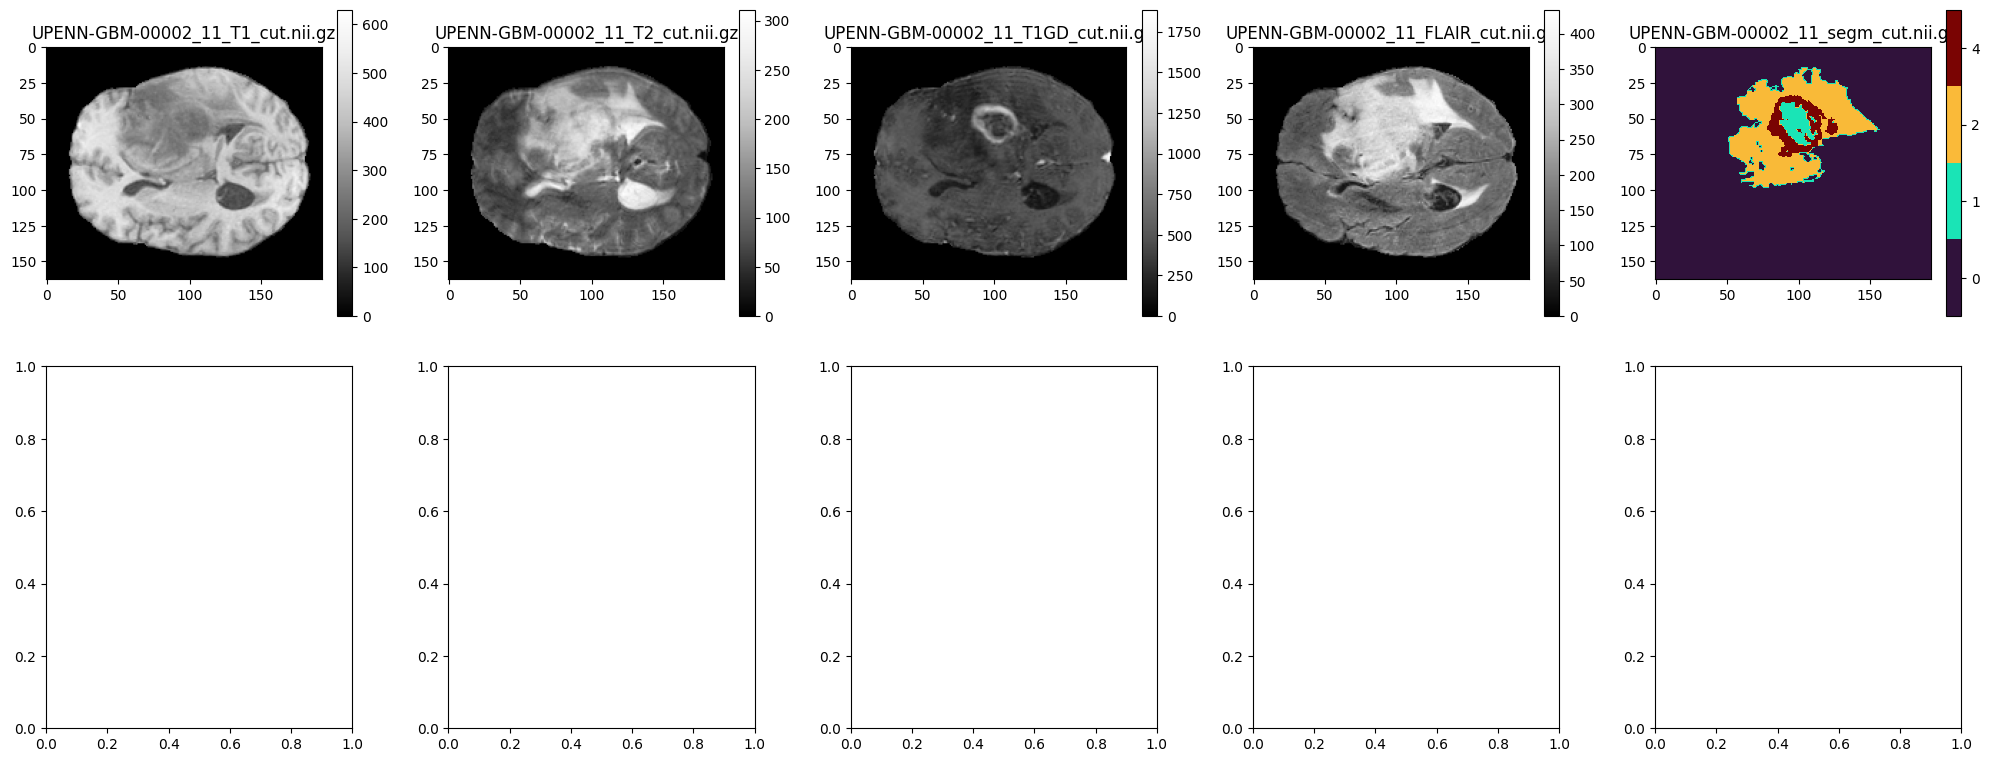

In [ ]:
# plot struct and corresponding reduced images
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
for col, struct_scan in enumerate(STRUCT_SCANS):

    # load and plot corresponding reduced images on the second column
    reduced_fname, reduced_nifti = load_nifti_img(subj_file=subj_file, struct_scan=struct_scan, reduced=True)
    plot_struct_img(img_data=reduced_nifti, fig=fig, axs=axs, row=0, col=col, title=reduced_fname)

# finally, add the segmentation label
# plot the reduced version of the segmented image
# load as both int and float
reduced_segm_fname, reduced_segm_nifti = load_nifti_img(subj_file=subj_file, segm=True, reduced=True, dtype='uint')
plot_segm_img(img_data=reduced_segm_nifti, fig=fig, axs=axs, row=0, col=4, title=reduced_segm_fname)

# show the figure
plt.tight_layout()
plt.show()

In [ ]:
# obtain image shape
n_h = reduced_nifti.shape[0]
n_w = reduced_nifti.shape[1]
n_d = reduced_nifti.shape[2]
print('Dimension of Image are height:',n_h,'width:',n_w,'depth:',n_d)

Dimension of Image are height: 163 width: 193 depth: 146


### 2.4 split data into train, val and test

In [ ]:
# obrain data splits on subjects
train_list, reserve_list = split_subjects(subjects, split_ratio=0.6, seed=2023)
val_list, test_list = split_subjects(reserve_list, split_ratio=0.5, seed=2023)

print(len(train_list))
print(len(val_list))
print(len(test_list))


88
30
29


In [ ]:
# torch.save(train_list,'train_list.py')
# torch.save(val_list,  'val_list.py')
# torch.save(test_list, 'test_list.py')

### 2.5 3D cube statistics and normalization test

In [ ]:
# array storing mean, min, max of image cubes
stats_arr = np.zeros( (len(subjects), len(STRUCT_SCANS), 4) )
print(stats_arr.shape)

images_all = np.zeros( (len(subjects), 4, n_h, n_w, n_d))

for idx1, subj_file in enumerate(subjects):
    print('Working on subject No.:',idx1+1,'/',len(subjects))
    for idx2, struct_scan in enumerate(STRUCT_SCANS):
        reduced_fname, reduced_nifti = load_nifti_img(subj_file=subj_file, struct_scan=struct_scan, reduced=True)
        mean_cur = reduced_nifti.mean()
        std_cur = reduced_nifti.std()
        min_cur = reduced_nifti.min()
        max_cur = reduced_nifti.max()
        stats_arr[idx1, idx2, 0] = mean_cur
        stats_arr[idx1, idx2, 1] = min_cur
        stats_arr[idx1, idx2, 2] = max_cur
        stats_arr[idx1, idx2, 3] = std_cur
        images_all[idx1, idx2, :, :, :] = reduced_nifti[:, :, :]

(147, 4, 4)
Working on subject No.: 1 / 147
Working on subject No.: 2 / 147
Working on subject No.: 3 / 147
Working on subject No.: 4 / 147
Working on subject No.: 5 / 147
Working on subject No.: 6 / 147
Working on subject No.: 7 / 147
Working on subject No.: 8 / 147
Working on subject No.: 9 / 147
Working on subject No.: 10 / 147
Working on subject No.: 11 / 147
Working on subject No.: 12 / 147
Working on subject No.: 13 / 147
Working on subject No.: 14 / 147
Working on subject No.: 15 / 147
Working on subject No.: 16 / 147
Working on subject No.: 17 / 147
Working on subject No.: 18 / 147
Working on subject No.: 19 / 147
Working on subject No.: 20 / 147
Working on subject No.: 21 / 147
Working on subject No.: 22 / 147
Working on subject No.: 23 / 147
Working on subject No.: 24 / 147
Working on subject No.: 25 / 147
Working on subject No.: 26 / 147
Working on subject No.: 27 / 147
Working on subject No.: 28 / 147
Working on subject No.: 29 / 147
Working on subject No.: 30 / 147
Working

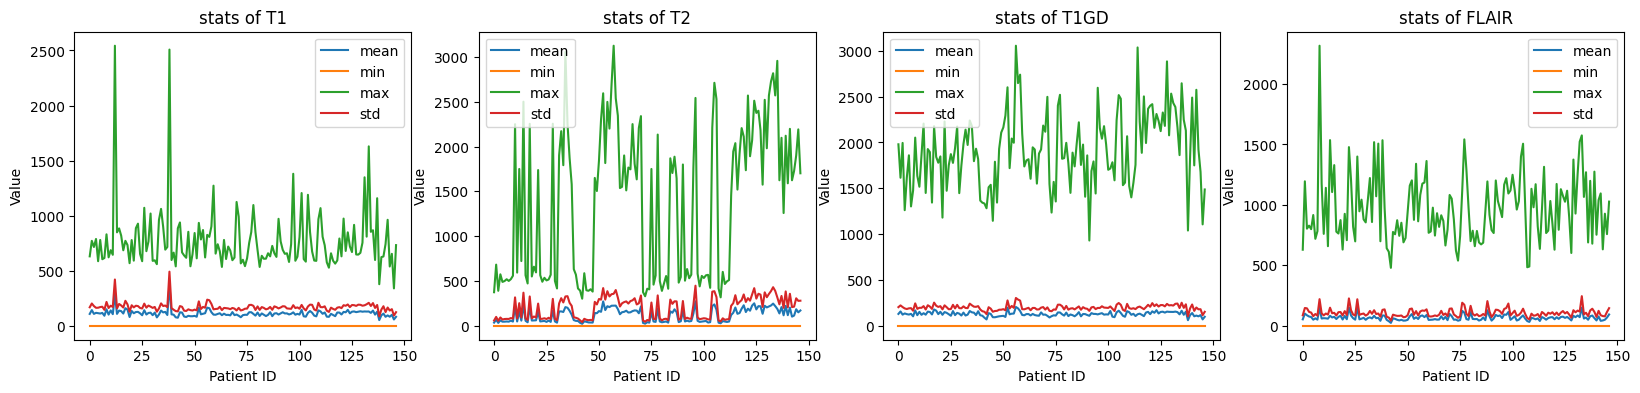

In [ ]:
fig, axes = plt.subplots(1, len(STRUCT_SCANS), figsize=(20, 4))

for idx, ax in enumerate(axes):
    ax.plot(stats_arr[:, idx, 0], label='mean')
    ax.plot(stats_arr[:, idx, 1], label='min')
    ax.plot(stats_arr[:, idx, 2], label='max')
    ax.plot(stats_arr[:, idx, 3], label='std')
    ax.set_title(f'stats of {STRUCT_SCANS[idx]}')
    ax.legend()
    ax.set_xlabel('Patient ID')
    ax.set_ylabel('Value')

plt.show()

In [ ]:
for idx1, subj_file in enumerate(subjects):
    print('Working on subject No.:',idx1+1,'/',len(subjects))
    for idx2, struct_scan in enumerate(STRUCT_SCANS):
        images_all[idx1, idx2, :, :, :] /= stats_arr[idx1, idx2, 2]


Working on subject No.: 1 / 147
Working on subject No.: 2 / 147
Working on subject No.: 3 / 147
Working on subject No.: 4 / 147
Working on subject No.: 5 / 147
Working on subject No.: 6 / 147
Working on subject No.: 7 / 147
Working on subject No.: 8 / 147
Working on subject No.: 9 / 147
Working on subject No.: 10 / 147
Working on subject No.: 11 / 147
Working on subject No.: 12 / 147
Working on subject No.: 13 / 147
Working on subject No.: 14 / 147
Working on subject No.: 15 / 147
Working on subject No.: 16 / 147
Working on subject No.: 17 / 147
Working on subject No.: 18 / 147
Working on subject No.: 19 / 147
Working on subject No.: 20 / 147
Working on subject No.: 21 / 147
Working on subject No.: 22 / 147
Working on subject No.: 23 / 147
Working on subject No.: 24 / 147
Working on subject No.: 25 / 147
Working on subject No.: 26 / 147
Working on subject No.: 27 / 147
Working on subject No.: 28 / 147
Working on subject No.: 29 / 147
Working on subject No.: 30 / 147
Working on subject 

In [ ]:
for idx1, subj_file in enumerate(subjects):
    print('Working on subject No.:',idx1+1,'/',len(subjects))
    for idx2, struct_scan in enumerate(STRUCT_SCANS):
        mean_cur = images_all[idx1, idx2, :, :, :].mean()
        std_cur  = images_all[idx1, idx2, :, :, :].std()
        min_cur  = images_all[idx1, idx2, :, :, :].min()
        max_cur  = images_all[idx1, idx2, :, :, :].max()
        stats_arr[idx1, idx2, 0] = mean_cur
        stats_arr[idx1, idx2, 1] = min_cur
        stats_arr[idx1, idx2, 2] = max_cur
        stats_arr[idx1, idx2, 3] = std_cur

Working on subject No.: 1 / 147
Working on subject No.: 2 / 147
Working on subject No.: 3 / 147
Working on subject No.: 4 / 147
Working on subject No.: 5 / 147
Working on subject No.: 6 / 147
Working on subject No.: 7 / 147
Working on subject No.: 8 / 147
Working on subject No.: 9 / 147
Working on subject No.: 10 / 147
Working on subject No.: 11 / 147
Working on subject No.: 12 / 147
Working on subject No.: 13 / 147
Working on subject No.: 14 / 147
Working on subject No.: 15 / 147
Working on subject No.: 16 / 147
Working on subject No.: 17 / 147
Working on subject No.: 18 / 147
Working on subject No.: 19 / 147
Working on subject No.: 20 / 147
Working on subject No.: 21 / 147
Working on subject No.: 22 / 147
Working on subject No.: 23 / 147
Working on subject No.: 24 / 147
Working on subject No.: 25 / 147
Working on subject No.: 26 / 147
Working on subject No.: 27 / 147
Working on subject No.: 28 / 147
Working on subject No.: 29 / 147
Working on subject No.: 30 / 147
Working on subject 

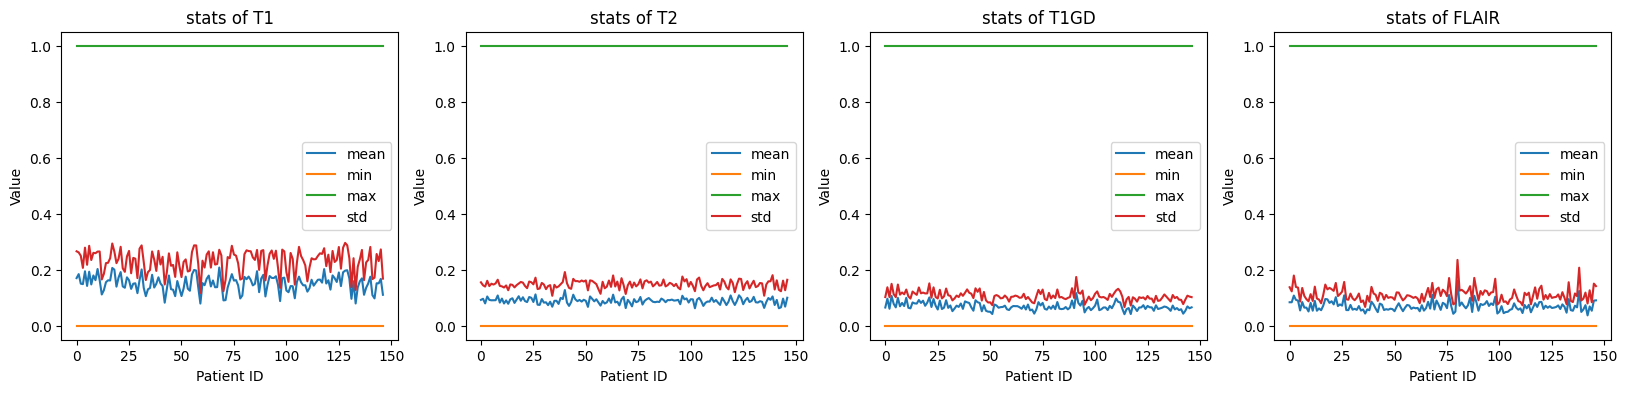

In [ ]:
fig, axes = plt.subplots(1, len(STRUCT_SCANS), figsize=(20, 4))

for idx, ax in enumerate(axes):
    ax.plot(stats_arr[:, idx, 0], label='mean')
    ax.plot(stats_arr[:, idx, 1], label='min')
    ax.plot(stats_arr[:, idx, 2], label='max')
    ax.plot(stats_arr[:, idx, 3], label='std')
    ax.set_title(f'stats of {STRUCT_SCANS[idx]}')
    ax.legend()
    ax.set_xlabel('Patient ID')
    ax.set_ylabel('Value')

plt.show()

### 2.6 Create normalized 3D cubes and output to files

In [ ]:
# array storing mean, min, max of image cubes
import gzip
import shutil

output_dir = 'data/images_annot_reduced_norm'
# make new dir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

f_name, f_path = get_img_path(subjects[0], struct_scan=STRUCT_SCANS[0], reduced=True)
nifti = nib.load(f_path)
nifti_struct_affine = nifti.affine
nifti_struct_header = nifti.header

stats_arr = np.zeros( (len(subjects), len(STRUCT_SCANS)) )

# normaliza data and save
for idx1, subj_file in enumerate(subjects):
    print('Working on subject No.:',idx1+1,'/',len(subjects))
    for idx2, struct_scan in enumerate(STRUCT_SCANS):
        # load 3D cube
        reduced_fname, reduced_nifti = load_nifti_img(subj_file=subj_file, struct_scan=struct_scan, reduced=True)
        # find max value
        max_cur = reduced_nifti.max()
        stats_arr[idx1, idx2] = max_cur
        # normalize cube by max
        reduced_nifti_norm = reduced_nifti / max_cur

        # setup output file
        output_nifti = nib.Nifti1Image(reduced_nifti_norm, nifti_struct_affine, nifti_struct_header)

        # save output
        save_fn = output_dir + '/' + subj_file + '_' + struct_scan + ".nii"
        nib.save(output_nifti, save_fn)

        # further compress to .gz file
        save_fn_gz = save_fn + '.gz'
        with open(save_fn, 'rb') as input_file:
            # Open the output .nii.gz file for writing in binary mode
            with gzip.open(save_fn_gz, 'wb') as output_file:
                # Copy the contents of the input file to the output file
                shutil.copyfileobj(input_file, output_file)

        # remove the un-compressed file
        os.remove(save_fn)

Working on subject No.: 1 / 147
Working on subject No.: 2 / 147
Working on subject No.: 3 / 147
Working on subject No.: 4 / 147
Working on subject No.: 5 / 147
Working on subject No.: 6 / 147
Working on subject No.: 7 / 147
Working on subject No.: 8 / 147
Working on subject No.: 9 / 147
Working on subject No.: 10 / 147
Working on subject No.: 11 / 147
Working on subject No.: 12 / 147
Working on subject No.: 13 / 147
Working on subject No.: 14 / 147
Working on subject No.: 15 / 147
Working on subject No.: 16 / 147
Working on subject No.: 17 / 147
Working on subject No.: 18 / 147
Working on subject No.: 19 / 147
Working on subject No.: 20 / 147
Working on subject No.: 21 / 147
Working on subject No.: 22 / 147
Working on subject No.: 23 / 147
Working on subject No.: 24 / 147
Working on subject No.: 25 / 147
Working on subject No.: 26 / 147
Working on subject No.: 27 / 147
Working on subject No.: 28 / 147
Working on subject No.: 29 / 147
Working on subject No.: 30 / 147
Working on subject 

In [ ]:
# obtain segm file names
segm_files = []
for my_file in reduced_files:
    if my_file.split('_')[2] == 'segm':
        segm_files.append(my_file)

# copy segm files
for my_file in segm_files:
    file_from = IMG_REDUCED_DIR + '/' + my_file
    file_to   = output_dir + '/' + my_file.split('_')[0] + '_' + my_file.split('_')[1] +\
                '_' + my_file.split('_')[2] + '.' + my_file.split('.')[1] + '.' + my_file.split('.')[2]
    !cp  $file_from $file_to

In [ ]:
# make zip files
! zip -rq images_annot_reduced_norm.zip data/images_annot_reduced_norm

#### QC normalized data

In [ ]:
# find all files
wkdir = output_dir

all_files = os.listdir(wkdir)
# sort files so they are ordered
all_files.sort()

# find all subjects
subjects = []
for my_file in all_files:
    subjects.append(my_file.split('_')[0] + "_" + my_file.split('_')[1])
subjects = list(set(subjects))
subjects.sort()

subjects_files = []
for my_file in subjects:
    cur_data = {}
    segm_file_name  = my_file + '_segm.nii.gz'
    T1_file_name    = my_file + '_T1.nii.gz'
    T2_file_name    = my_file + '_T2.nii.gz'
    T1GD_file_name  = my_file + '_T1GD.nii.gz'
    FLAIR_file_name = my_file + '_FLAIR.nii.gz'
    cur_data['segm'] = wkdir + '/' + segm_file_name
    cur_data['T1'] = wkdir + '/' + T1_file_name
    cur_data['T2'] = wkdir + '/' + T2_file_name
    cur_data['T1GD'] = wkdir + '/' + T1GD_file_name
    cur_data['FLAIR'] = wkdir + '/' + FLAIR_file_name
    subjects_files.append(cur_data)

print(subjects_files[:2])

[{'segm': 'data/images_annot_reduced_norm/UPENN-GBM-00002_11_segm.nii.gz', 'T1': 'data/images_annot_reduced_norm/UPENN-GBM-00002_11_T1.nii.gz', 'T2': 'data/images_annot_reduced_norm/UPENN-GBM-00002_11_T2.nii.gz', 'T1GD': 'data/images_annot_reduced_norm/UPENN-GBM-00002_11_T1GD.nii.gz', 'FLAIR': 'data/images_annot_reduced_norm/UPENN-GBM-00002_11_FLAIR.nii.gz'}, {'segm': 'data/images_annot_reduced_norm/UPENN-GBM-00006_11_segm.nii.gz', 'T1': 'data/images_annot_reduced_norm/UPENN-GBM-00006_11_T1.nii.gz', 'T2': 'data/images_annot_reduced_norm/UPENN-GBM-00006_11_T2.nii.gz', 'T1GD': 'data/images_annot_reduced_norm/UPENN-GBM-00006_11_T1GD.nii.gz', 'FLAIR': 'data/images_annot_reduced_norm/UPENN-GBM-00006_11_FLAIR.nii.gz'}]


Working on sample No. 0 display slide No. 68  with  4973 non-zero pixels in label.
Working on sample No. 1 display slide No. 53  with  2110 non-zero pixels in label.
Working on sample No. 2 display slide No. 93  with  946 non-zero pixels in label.
Working on sample No. 3 display slide No. 91  with  2516 non-zero pixels in label.
Working on sample No. 4 display slide No. 86  with  2740 non-zero pixels in label.
Working on sample No. 5 display slide No. 95  with  774 non-zero pixels in label.
Working on sample No. 6 display slide No. 93  with  3143 non-zero pixels in label.
Working on sample No. 7 display slide No. 60  with  1497 non-zero pixels in label.
Working on sample No. 8 display slide No. 42  with  1272 non-zero pixels in label.
Working on sample No. 9 display slide No. 66  with  4219 non-zero pixels in label.
Working on sample No. 10 display slide No. 77  with  997 non-zero pixels in label.
Working on sample No. 11 display slide No. 87  with  1338 non-zero pixels in label.
Worki

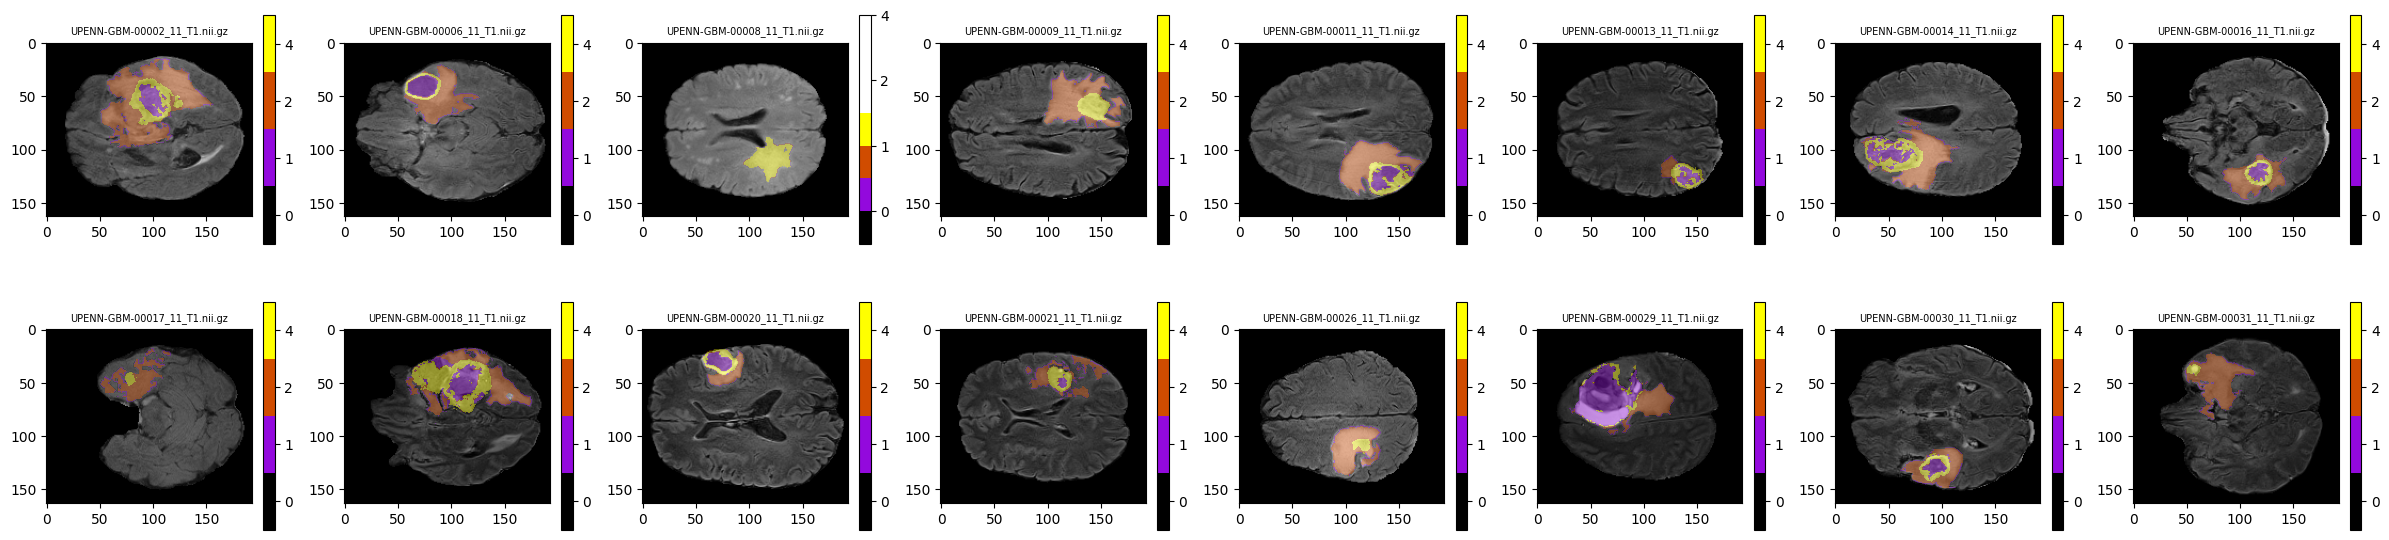

In [ ]:
# visualize the structural images and its corresponding manually-revised
# segmentation label for starters

# set the number of plots per row and column
# Warning: needs high-RAM machine to run all (e.g. >80) plots
# nrows = 19
nrows = 2
ncols = 8

# set a constant color scale for all structure images
img_max = 1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols,3*nrows))

# iteratively load the file structural images and display them
for idx in range(nrows*ncols):
    # go until no more samples
    if idx >= len(segm_files):
        break

    # first, get the segmentation label
    # calculate a discrete colorbar for the labels
    label_mask = nib.load(subjects_files[idx]['segm'])
    label_names = np.unique(label_mask.get_fdata().astype('uint'))
    num_labels = len(label_names)
    label_cmap = plt.get_cmap('gnuplot', num_labels)
    # because it is difficult to find a nice colorbar that works well with alpha
    # blending, create an alpha masking array to make any pixel with a label value
    # of 0 equal to alpha=0, and all else 0.4
    alpha_mask = np.where(label_mask.get_fdata().astype('uint') == 0, 0, 0.4)

    # find the slide with most non-zero annotations
    # Count the number of non-zero elements in each slice along the 0th axis
    nonzero_counts = np.sum( np.count_nonzero(label_mask.get_fdata().astype('uint'), axis=0), axis=0 )

    # Find the index of the slice with the maximum count
    slice_idx = np.argmax(nonzero_counts)
    print("Working on sample No.", idx, "display slide No.", slice_idx, " with ", nonzero_counts[slice_idx], "non-zero pixels in label.")

    nifti_path = subjects_files[idx]['FLAIR']
    nifti = nib.load(nifti_path)

    # determine which row/col to plot the current axs
    row = idx // ncols
    col = idx % ncols

    # add the image to the current axs
    img = axs[row, col].imshow(nifti.get_fdata()[:, :, slice_idx], aspect='equal', cmap='Greys_r', vmin=0, vmax=img_max)
    mask = axs[row, col].imshow(
        label_mask.get_fdata().astype('uint')[:, :, slice_idx],
        aspect='equal', cmap=label_cmap, alpha=alpha_mask[:, :, slice_idx])

    axs[row, col].set_title(subjects_files[idx]['T1'].split('/')[-1], fontsize = 7)
    mask_cbar = fig.colorbar(mask, ax=axs[row, col], fraction=0.05)
    # set the tick locs and adjust the cbar
    mask_cbar.set_ticks([tick + 0.5 for tick in range(num_labels)])
    mask_cbar.set_ticklabels(label_names)

# show the figure
plt.tight_layout()
# fig.savefig('example_all_sample.pdf', format='pdf')

Working on sample No. 0 display slide No. 68  with  4973 non-zero pixels in label.
Working on sample No. 1 display slide No. 53  with  2110 non-zero pixels in label.
Working on sample No. 2 display slide No. 93  with  946 non-zero pixels in label.
Working on sample No. 3 display slide No. 91  with  2516 non-zero pixels in label.
Working on sample No. 4 display slide No. 86  with  2740 non-zero pixels in label.
Working on sample No. 5 display slide No. 95  with  774 non-zero pixels in label.
Working on sample No. 6 display slide No. 93  with  3143 non-zero pixels in label.
Working on sample No. 7 display slide No. 60  with  1497 non-zero pixels in label.
Working on sample No. 8 display slide No. 42  with  1272 non-zero pixels in label.
Working on sample No. 9 display slide No. 66  with  4219 non-zero pixels in label.
Working on sample No. 10 display slide No. 77  with  997 non-zero pixels in label.
Working on sample No. 11 display slide No. 87  with  1338 non-zero pixels in label.
Worki

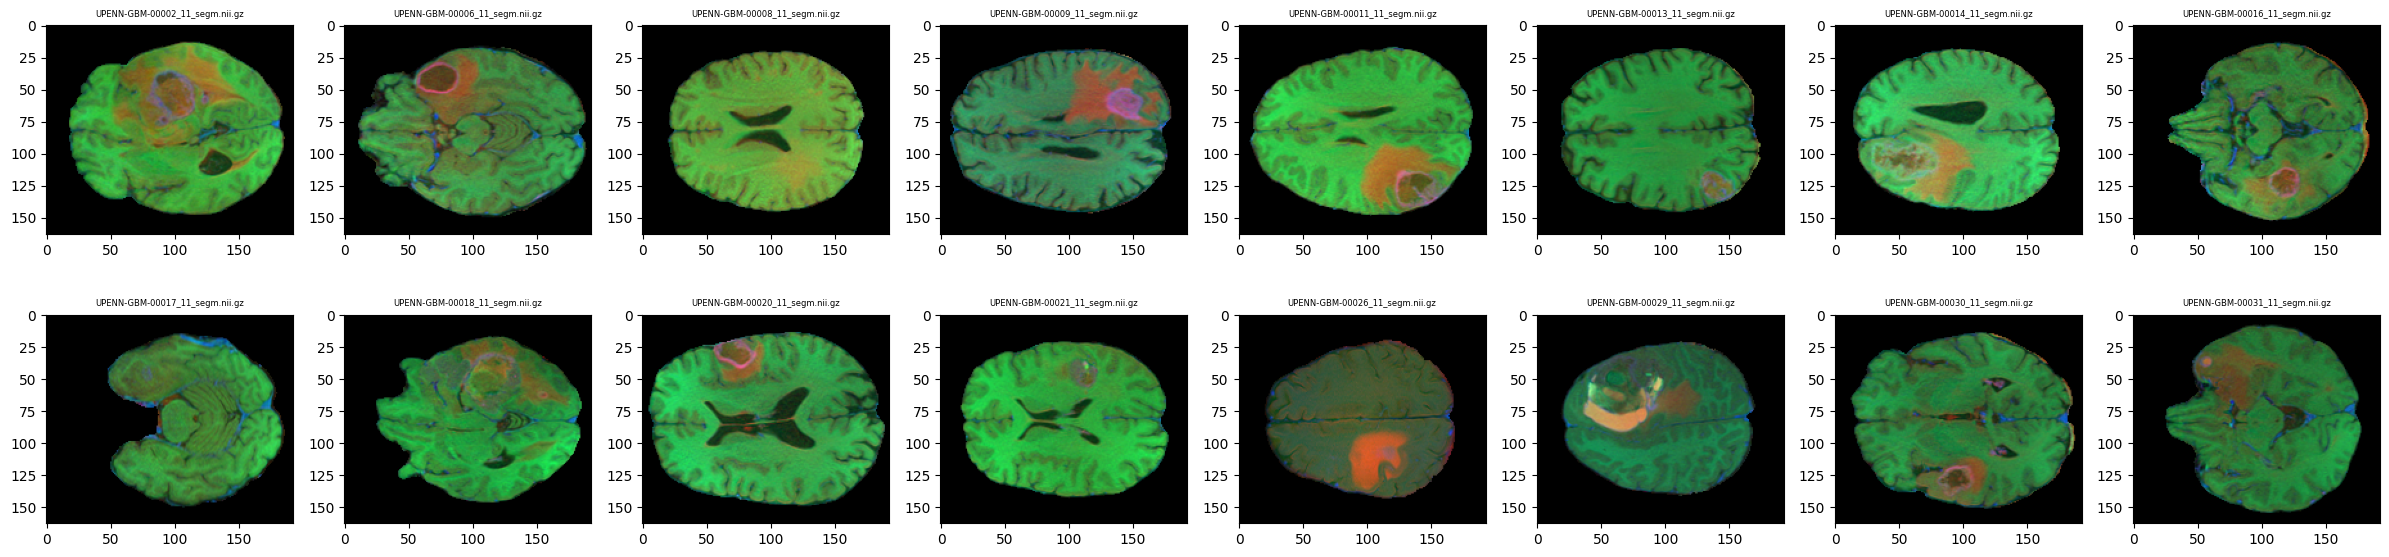

In [ ]:
# visualize the structural images and its corresponding manually-revised
# segmentation label for starters

# set the number of plots per row and column
# Warning: needs high-RAM machine to run all (e.g. >80) plots
# nrows = 19
nrows = 2
ncols = 8

# set a constant color scale for all structure images
img_max = 1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols,3*nrows))

# iteratively load the file structural images and display them
for idx in range(nrows*ncols):
    # go until no more samples
    if idx >= len(segm_files):
        break

    # first, get the segmentation label
    # calculate a discrete colorbar for the labels
    label_mask = nib.load(subjects_files[idx]['segm'])
    label_names = np.unique(label_mask.get_fdata().astype('uint'))
    num_labels = len(label_names)
    label_cmap = plt.get_cmap('gnuplot', num_labels)
    # because it is difficult to find a nice colorbar that works well with alpha
    # blending, create an alpha masking array to make any pixel with a label value
    # of 0 equal to alpha=0, and all else 0.4
    alpha_mask = np.where(label_mask.get_fdata().astype('uint') == 0, 0, 0.4)

    # find the slide with most non-zero annotations
    # Count the number of non-zero elements in each slice along the 0th axis
    nonzero_counts = np.sum( np.count_nonzero(label_mask.get_fdata().astype('uint'), axis=0), axis=0 )

    # Find the index of the slice with the maximum count
    slice_idx = np.argmax(nonzero_counts)
    print("Working on sample No.", idx, "display slide No.", slice_idx, " with ", nonzero_counts[slice_idx], "non-zero pixels in label.")

    nifti_path = subjects_files[idx]['FLAIR']
    nifti = nib.load(nifti_path)
    image_cur = np.zeros( (nifti.shape[0], nifti.shape[1], 3) )
    image_cur[:,:,0] = nifti.get_fdata()[:, :, slice_idx]
    nifti_path = subjects_files[idx]['T1']
    nifti = nib.load(nifti_path)
    image_cur[:,:,1] = nifti.get_fdata()[:, :, slice_idx]
    nifti_path = subjects_files[idx]['T1GD']
    nifti = nib.load(nifti_path)
    image_cur[:,:,2] = nifti.get_fdata()[:, :, slice_idx]

    # determine which row/col to plot the current axs
    row = idx // ncols
    col = idx % ncols

    # add the image to the current axs
    img = axs[row, col].imshow(image_cur, aspect='equal', vmin=0, vmax=img_max)

    axs[row, col].set_title(subjects_files[idx]['segm'].split('/')[-1], fontsize = 6)

# show the figure
plt.tight_layout()
# fig.savefig('example_all_sample.pdf', format='pdf')

### 2.7 Create 2D data from 3D data

#### depth train and val

In [ ]:
# creating 2D data slices from 3D data

import gzip
import shutil

# manually choose:
# 1)which data split to process
# 2) output dir
# 3) slicing direction
split_choices = ['train', 'val', 'test']
slice_choices = ['cross_front', 'cross_side', 'depth']

# run one of the selections below

# train set in depth direction
subject_list = train_list
data_2d_dir = DATA_DIR + '/train_2d'
slice_choice = slice_choices[2]

# val set in depth direction
# subject_list = val_list
# data_2d_dir = DATA_DIR + '/val_2d'
# slice_choice = slice_choices[2]

# train set in cross direction
# subject_list = train_list
# data_2d_dir = DATA_DIR + '/train_2d_cross'
# slice_choice = slice_choices[1]

# val set in cross direction
# subject_list = val_list
# data_2d_dir = DATA_DIR + '/val_2d_cross'
# slice_choice = slice_choices[1]

# train set in cross_front direction
# subject_list = train_list
# split_choice = split_choices[0]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# val set in cross_front direction
# subject_list = val_list
# split_choice = split_choices[1]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in depth direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[2]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in cross direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[1]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in cross_front direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# obtain basic info
f_name, f_path = get_img_path(subject_list[0], struct_scan=STRUCT_SCANS[0], reduced=True)
nifti = nib.load(f_path)
nifti_struct_affine = nifti.affine
nifti_struct_header = nifti.header

f_name, f_path = get_img_path(subject_list[0],  segm=True, reduced=True)
nifti = nib.load(f_path)
nifti_sesgm_affine = nifti.affine
nifti_segm_header = nifti.header

# make new dir
if not os.path.exists(data_2d_dir):
    os.makedirs(data_2d_dir)

# for each file, save all depth slides to seperate files
for subj_file in subject_list:
    index = subjects.index(subj_file)
    print('Working on subject:',subj_file)
    for struct_scan in STRUCT_SCANS:
        nifti = nib.load(subjects_files[index][struct_scan])

        # save 2d slices for each structure file
        if slice_choice == 'depth':
            for idx in range(n_d):
                sliced_data = nifti.get_fdata()[:, :, idx]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        elif slice_choice == 'cross_side':
            for idx in range(n_h):
                sliced_data = nifti.get_fdata()[idx, :, :]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        elif slice_choice == 'cross_front':
            for idx in range(n_w):
                sliced_data = nifti.get_fdata()[:, idx, :]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        else:
            print("Warning: slicing choice is not valid.")
            break

    # save 2d slices for segm file
    nifti = nib.load(subjects_files[index]['segm'])

    if slice_choice == 'depth':
        for idx in range(n_d):
            sliced_data =  nifti.get_fdata()[:, :, idx]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    elif slice_choice == 'cross_side':
        for idx in range(n_h):
            sliced_data =  nifti.get_fdata()[idx, :, :]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    elif slice_choice == 'cross_front':
        for idx in range(n_w):
            sliced_data =  nifti.get_fdata()[:, idx, :]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    else:
        print("Warning: slicing choice is not valid.")
        break


Working on subject: UPENN-GBM-00251_11
Working on subject: UPENN-GBM-00285_11
Working on subject: UPENN-GBM-00252_11
Working on subject: UPENN-GBM-00189_11
Working on subject: UPENN-GBM-00201_11
Working on subject: UPENN-GBM-00066_11
Working on subject: UPENN-GBM-00082_11
Working on subject: UPENN-GBM-00174_11
Working on subject: UPENN-GBM-00393_11
Working on subject: UPENN-GBM-00391_11
Working on subject: UPENN-GBM-00404_11
Working on subject: UPENN-GBM-00112_11
Working on subject: UPENN-GBM-00137_11
Working on subject: UPENN-GBM-00398_11
Working on subject: UPENN-GBM-00011_11
Working on subject: UPENN-GBM-00122_11
Working on subject: UPENN-GBM-00226_11
Working on subject: UPENN-GBM-00035_11
Working on subject: UPENN-GBM-00083_11
Working on subject: UPENN-GBM-00018_11
Working on subject: UPENN-GBM-00428_11
Working on subject: UPENN-GBM-00041_11
Working on subject: UPENN-GBM-00362_11
Working on subject: UPENN-GBM-00139_11
Working on subject: UPENN-GBM-00290_11
Working on subject: UPENN

In [ ]:
! zip -rq train_2d_new.zip data/train_2d

In [ ]:
# creating 2D data slices from 3D data

import gzip
import shutil

# manually choose:
# 1)which data split to process
# 2) output dir
# 3) slicing direction
split_choices = ['train', 'val', 'test']
slice_choices = ['cross_front', 'cross_side', 'depth']

# run one of the selections below

# train set in depth direction
# subject_list = train_list
# data_2d_dir = DATA_DIR + '/train_2d'
# slice_choice = slice_choices[2]

# val set in depth direction
subject_list = val_list
data_2d_dir = DATA_DIR + '/val_2d'
slice_choice = slice_choices[2]

# train set in cross direction
# subject_list = train_list
# data_2d_dir = DATA_DIR + '/train_2d_cross'
# slice_choice = slice_choices[1]

# val set in cross direction
# subject_list = val_list
# data_2d_dir = DATA_DIR + '/val_2d_cross'
# slice_choice = slice_choices[1]

# train set in cross_front direction
# subject_list = train_list
# split_choice = split_choices[0]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# val set in cross_front direction
# subject_list = val_list
# split_choice = split_choices[1]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in depth direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[2]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in cross direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[1]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in cross_front direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# obtain basic info
f_name, f_path = get_img_path(subject_list[0], struct_scan=STRUCT_SCANS[0], reduced=True)
nifti = nib.load(f_path)
nifti_struct_affine = nifti.affine
nifti_struct_header = nifti.header

f_name, f_path = get_img_path(subject_list[0],  segm=True, reduced=True)
nifti = nib.load(f_path)
nifti_sesgm_affine = nifti.affine
nifti_segm_header = nifti.header

# make new dir
if not os.path.exists(data_2d_dir):
    os.makedirs(data_2d_dir)

# for each file, save all depth slides to seperate files
for subj_file in subject_list:
    index = subjects.index(subj_file)
    print('Working on subject:',subj_file)
    for struct_scan in STRUCT_SCANS:
        nifti = nib.load(subjects_files[index][struct_scan])

        # save 2d slices for each structure file
        if slice_choice == 'depth':
            for idx in range(n_d):
                sliced_data = nifti.get_fdata()[:, :, idx]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        elif slice_choice == 'cross_side':
            for idx in range(n_h):
                sliced_data = nifti.get_fdata()[idx, :, :]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        elif slice_choice == 'cross_front':
            for idx in range(n_w):
                sliced_data = nifti.get_fdata()[:, idx, :]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        else:
            print("Warning: slicing choice is not valid.")
            break

    # save 2d slices for segm file
    nifti = nib.load(subjects_files[index]['segm'])

    if slice_choice == 'depth':
        for idx in range(n_d):
            sliced_data =  nifti.get_fdata()[:, :, idx]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    elif slice_choice == 'cross_side':
        for idx in range(n_h):
            sliced_data =  nifti.get_fdata()[idx, :, :]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    elif slice_choice == 'cross_front':
        for idx in range(n_w):
            sliced_data =  nifti.get_fdata()[:, idx, :]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    else:
        print("Warning: slicing choice is not valid.")
        break


Working on subject: UPENN-GBM-00144_11
Working on subject: UPENN-GBM-00261_11
Working on subject: UPENN-GBM-00151_11
Working on subject: UPENN-GBM-00380_11
Working on subject: UPENN-GBM-00474_11
Working on subject: UPENN-GBM-00124_11
Working on subject: UPENN-GBM-00240_11
Working on subject: UPENN-GBM-00217_11
Working on subject: UPENN-GBM-00131_11
Working on subject: UPENN-GBM-00249_11
Working on subject: UPENN-GBM-00030_11
Working on subject: UPENN-GBM-00033_11
Working on subject: UPENN-GBM-00253_11
Working on subject: UPENN-GBM-00118_11
Working on subject: UPENN-GBM-00439_11
Working on subject: UPENN-GBM-00206_11
Working on subject: UPENN-GBM-00205_11
Working on subject: UPENN-GBM-00264_11
Working on subject: UPENN-GBM-00075_11
Working on subject: UPENN-GBM-00101_11
Working on subject: UPENN-GBM-00284_11
Working on subject: UPENN-GBM-00008_11
Working on subject: UPENN-GBM-00100_11
Working on subject: UPENN-GBM-00140_11
Working on subject: UPENN-GBM-00020_11
Working on subject: UPENN

In [ ]:
! zip -rq val_2d_new.zip data/val_2d

#### cross_side train and val

In [ ]:
# creating 2D data slices from 3D data

import gzip
import shutil

# manually choose:
# 1)which data split to process
# 2) output dir
# 3) slicing direction
split_choices = ['train', 'val', 'test']
slice_choices = ['cross_front', 'cross_side', 'depth']

# run one of the selections below

# train set in depth direction
# subject_list = train_list
# data_2d_dir = DATA_DIR + '/train_2d'
# slice_choice = slice_choices[2]

# val set in depth direction
# subject_list = val_list
# data_2d_dir = DATA_DIR + '/val_2d'
# slice_choice = slice_choices[2]

# train set in cross direction
subject_list = train_list
data_2d_dir = DATA_DIR + '/train_2d_cross'
slice_choice = slice_choices[1]

# val set in cross direction
# subject_list = val_list
# data_2d_dir = DATA_DIR + '/val_2d_cross'
# slice_choice = slice_choices[1]

# train set in cross_front direction
# subject_list = train_list
# split_choice = split_choices[0]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# val set in cross_front direction
# subject_list = val_list
# split_choice = split_choices[1]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in depth direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[2]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in cross direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[1]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in cross_front direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# obtain basic info
f_name, f_path = get_img_path(subject_list[0], struct_scan=STRUCT_SCANS[0], reduced=True)
nifti = nib.load(f_path)
nifti_struct_affine = nifti.affine
nifti_struct_header = nifti.header

f_name, f_path = get_img_path(subject_list[0],  segm=True, reduced=True)
nifti = nib.load(f_path)
nifti_sesgm_affine = nifti.affine
nifti_segm_header = nifti.header

# make new dir
if not os.path.exists(data_2d_dir):
    os.makedirs(data_2d_dir)

# for each file, save all depth slides to seperate files
for subj_file in subject_list:
    index = subjects.index(subj_file)
    print('Working on subject:',subj_file)
    for struct_scan in STRUCT_SCANS:
        nifti = nib.load(subjects_files[index][struct_scan])

        # save 2d slices for each structure file
        if slice_choice == 'depth':
            for idx in range(n_d):
                sliced_data = nifti.get_fdata()[:, :, idx]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        elif slice_choice == 'cross_side':
            for idx in range(n_h):
                sliced_data = nifti.get_fdata()[idx, :, :]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        elif slice_choice == 'cross_front':
            for idx in range(n_w):
                sliced_data = nifti.get_fdata()[:, idx, :]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        else:
            print("Warning: slicing choice is not valid.")
            break

    # save 2d slices for segm file
    nifti = nib.load(subjects_files[index]['segm'])

    if slice_choice == 'depth':
        for idx in range(n_d):
            sliced_data =  nifti.get_fdata()[:, :, idx]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    elif slice_choice == 'cross_side':
        for idx in range(n_h):
            sliced_data =  nifti.get_fdata()[idx, :, :]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    elif slice_choice == 'cross_front':
        for idx in range(n_w):
            sliced_data =  nifti.get_fdata()[:, idx, :]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    else:
        print("Warning: slicing choice is not valid.")
        break


Working on subject: UPENN-GBM-00251_11
Working on subject: UPENN-GBM-00285_11
Working on subject: UPENN-GBM-00252_11
Working on subject: UPENN-GBM-00189_11
Working on subject: UPENN-GBM-00201_11
Working on subject: UPENN-GBM-00066_11
Working on subject: UPENN-GBM-00082_11
Working on subject: UPENN-GBM-00174_11
Working on subject: UPENN-GBM-00393_11
Working on subject: UPENN-GBM-00391_11
Working on subject: UPENN-GBM-00404_11
Working on subject: UPENN-GBM-00112_11
Working on subject: UPENN-GBM-00137_11
Working on subject: UPENN-GBM-00398_11
Working on subject: UPENN-GBM-00011_11
Working on subject: UPENN-GBM-00122_11
Working on subject: UPENN-GBM-00226_11
Working on subject: UPENN-GBM-00035_11
Working on subject: UPENN-GBM-00083_11
Working on subject: UPENN-GBM-00018_11
Working on subject: UPENN-GBM-00428_11
Working on subject: UPENN-GBM-00041_11
Working on subject: UPENN-GBM-00362_11
Working on subject: UPENN-GBM-00139_11
Working on subject: UPENN-GBM-00290_11
Working on subject: UPENN

In [ ]:
! zip -rq train_2d_cross_new.zip data/train_2d_cross

In [ ]:
# creating 2D data slices from 3D data

import gzip
import shutil

# manually choose:
# 1)which data split to process
# 2) output dir
# 3) slicing direction
split_choices = ['train', 'val', 'test']
slice_choices = ['cross_front', 'cross_side', 'depth']

# run one of the selections below

# train set in depth direction
# subject_list = train_list
# data_2d_dir = DATA_DIR + '/train_2d'
# slice_choice = slice_choices[2]

# val set in depth direction
# subject_list = val_list
# data_2d_dir = DATA_DIR + '/val_2d'
# slice_choice = slice_choices[2]

# train set in cross direction
# subject_list = train_list
# data_2d_dir = DATA_DIR + '/train_2d_cross'
# slice_choice = slice_choices[1]

# val set in cross direction
subject_list = val_list
data_2d_dir = DATA_DIR + '/val_2d_cross'
slice_choice = slice_choices[1]

# train set in cross_front direction
# subject_list = train_list
# split_choice = split_choices[0]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# val set in cross_front direction
# subject_list = val_list
# split_choice = split_choices[1]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in depth direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[2]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in cross direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[1]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in cross_front direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# obtain basic info
f_name, f_path = get_img_path(subject_list[0], struct_scan=STRUCT_SCANS[0], reduced=True)
nifti = nib.load(f_path)
nifti_struct_affine = nifti.affine
nifti_struct_header = nifti.header

f_name, f_path = get_img_path(subject_list[0],  segm=True, reduced=True)
nifti = nib.load(f_path)
nifti_sesgm_affine = nifti.affine
nifti_segm_header = nifti.header

# make new dir
if not os.path.exists(data_2d_dir):
    os.makedirs(data_2d_dir)

# for each file, save all depth slides to seperate files
for subj_file in subject_list:
    index = subjects.index(subj_file)
    print('Working on subject:',subj_file)
    for struct_scan in STRUCT_SCANS:
        nifti = nib.load(subjects_files[index][struct_scan])

        # save 2d slices for each structure file
        if slice_choice == 'depth':
            for idx in range(n_d):
                sliced_data = nifti.get_fdata()[:, :, idx]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        elif slice_choice == 'cross_side':
            for idx in range(n_h):
                sliced_data = nifti.get_fdata()[idx, :, :]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        elif slice_choice == 'cross_front':
            for idx in range(n_w):
                sliced_data = nifti.get_fdata()[:, idx, :]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        else:
            print("Warning: slicing choice is not valid.")
            break

    # save 2d slices for segm file
    nifti = nib.load(subjects_files[index]['segm'])

    if slice_choice == 'depth':
        for idx in range(n_d):
            sliced_data =  nifti.get_fdata()[:, :, idx]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    elif slice_choice == 'cross_side':
        for idx in range(n_h):
            sliced_data =  nifti.get_fdata()[idx, :, :]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    elif slice_choice == 'cross_front':
        for idx in range(n_w):
            sliced_data =  nifti.get_fdata()[:, idx, :]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    else:
        print("Warning: slicing choice is not valid.")
        break


Working on subject: UPENN-GBM-00144_11
Working on subject: UPENN-GBM-00261_11
Working on subject: UPENN-GBM-00151_11
Working on subject: UPENN-GBM-00380_11
Working on subject: UPENN-GBM-00474_11
Working on subject: UPENN-GBM-00124_11
Working on subject: UPENN-GBM-00240_11
Working on subject: UPENN-GBM-00217_11
Working on subject: UPENN-GBM-00131_11
Working on subject: UPENN-GBM-00249_11
Working on subject: UPENN-GBM-00030_11
Working on subject: UPENN-GBM-00033_11
Working on subject: UPENN-GBM-00253_11
Working on subject: UPENN-GBM-00118_11
Working on subject: UPENN-GBM-00439_11
Working on subject: UPENN-GBM-00206_11
Working on subject: UPENN-GBM-00205_11
Working on subject: UPENN-GBM-00264_11
Working on subject: UPENN-GBM-00075_11
Working on subject: UPENN-GBM-00101_11
Working on subject: UPENN-GBM-00284_11
Working on subject: UPENN-GBM-00008_11
Working on subject: UPENN-GBM-00100_11
Working on subject: UPENN-GBM-00140_11
Working on subject: UPENN-GBM-00020_11
Working on subject: UPENN

In [ ]:
! zip -rq val_2d_cross_new.zip data/val_2d_cross

#### cross_front train and val

In [ ]:
# creating 2D data slices from 3D data

import gzip
import shutil

# manually choose:
# 1)which data split to process
# 2) output dir
# 3) slicing direction
split_choices = ['train', 'val', 'test']
slice_choices = ['cross_front', 'cross_side', 'depth']

# run one of the selections below

# train set in depth direction
# subject_list = train_list
# data_2d_dir = DATA_DIR + '/train_2d'
# slice_choice = slice_choices[2]

# val set in depth direction
# subject_list = val_list
# data_2d_dir = DATA_DIR + '/val_2d'
# slice_choice = slice_choices[2]

# train set in cross direction
# subject_list = train_list
# data_2d_dir = DATA_DIR + '/train_2d_cross'
# slice_choice = slice_choices[1]

# val set in cross direction
# subject_list = val_list
# data_2d_dir = DATA_DIR + '/val_2d_cross'
# slice_choice = slice_choices[1]

# train set in cross_front direction
subject_list = train_list
split_choice = split_choices[0]
slice_choice = slice_choices[0]
data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# val set in cross_front direction
# subject_list = val_list
# split_choice = split_choices[1]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in depth direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[2]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in cross direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[1]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in cross_front direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# obtain basic info
f_name, f_path = get_img_path(subject_list[0], struct_scan=STRUCT_SCANS[0], reduced=True)
nifti = nib.load(f_path)
nifti_struct_affine = nifti.affine
nifti_struct_header = nifti.header

f_name, f_path = get_img_path(subject_list[0],  segm=True, reduced=True)
nifti = nib.load(f_path)
nifti_sesgm_affine = nifti.affine
nifti_segm_header = nifti.header

# make new dir
if not os.path.exists(data_2d_dir):
    os.makedirs(data_2d_dir)

# for each file, save all depth slides to seperate files
for subj_file in subject_list:
    index = subjects.index(subj_file)
    print('Working on subject:',subj_file)
    for struct_scan in STRUCT_SCANS:
        nifti = nib.load(subjects_files[index][struct_scan])

        # save 2d slices for each structure file
        if slice_choice == 'depth':
            for idx in range(n_d):
                sliced_data = nifti.get_fdata()[:, :, idx]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        elif slice_choice == 'cross_side':
            for idx in range(n_h):
                sliced_data = nifti.get_fdata()[idx, :, :]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        elif slice_choice == 'cross_front':
            for idx in range(n_w):
                sliced_data = nifti.get_fdata()[:, idx, :]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        else:
            print("Warning: slicing choice is not valid.")
            break

    # save 2d slices for segm file
    nifti = nib.load(subjects_files[index]['segm'])

    if slice_choice == 'depth':
        for idx in range(n_d):
            sliced_data =  nifti.get_fdata()[:, :, idx]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    elif slice_choice == 'cross_side':
        for idx in range(n_h):
            sliced_data =  nifti.get_fdata()[idx, :, :]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    elif slice_choice == 'cross_front':
        for idx in range(n_w):
            sliced_data =  nifti.get_fdata()[:, idx, :]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    else:
        print("Warning: slicing choice is not valid.")
        break


Working on subject: UPENN-GBM-00251_11
Working on subject: UPENN-GBM-00285_11
Working on subject: UPENN-GBM-00252_11
Working on subject: UPENN-GBM-00189_11
Working on subject: UPENN-GBM-00201_11
Working on subject: UPENN-GBM-00066_11
Working on subject: UPENN-GBM-00082_11
Working on subject: UPENN-GBM-00174_11
Working on subject: UPENN-GBM-00393_11
Working on subject: UPENN-GBM-00391_11
Working on subject: UPENN-GBM-00404_11
Working on subject: UPENN-GBM-00112_11
Working on subject: UPENN-GBM-00137_11
Working on subject: UPENN-GBM-00398_11
Working on subject: UPENN-GBM-00011_11
Working on subject: UPENN-GBM-00122_11
Working on subject: UPENN-GBM-00226_11
Working on subject: UPENN-GBM-00035_11
Working on subject: UPENN-GBM-00083_11
Working on subject: UPENN-GBM-00018_11
Working on subject: UPENN-GBM-00428_11
Working on subject: UPENN-GBM-00041_11
Working on subject: UPENN-GBM-00362_11
Working on subject: UPENN-GBM-00139_11
Working on subject: UPENN-GBM-00290_11
Working on subject: UPENN

In [ ]:
! zip -rq train_2d_cross_front_new.zip data/train_2d_cross_front

In [ ]:
# creating 2D data slices from 3D data

import gzip
import shutil

# manually choose:
# 1)which data split to process
# 2) output dir
# 3) slicing direction
split_choices = ['train', 'val', 'test']
slice_choices = ['cross_front', 'cross_side', 'depth']

# run one of the selections below

# train set in depth direction
# subject_list = train_list
# data_2d_dir = DATA_DIR + '/train_2d'
# slice_choice = slice_choices[2]

# val set in depth direction
# subject_list = val_list
# data_2d_dir = DATA_DIR + '/val_2d'
# slice_choice = slice_choices[2]

# train set in cross direction
# subject_list = train_list
# data_2d_dir = DATA_DIR + '/train_2d_cross'
# slice_choice = slice_choices[1]

# val set in cross direction
# subject_list = val_list
# data_2d_dir = DATA_DIR + '/val_2d_cross'
# slice_choice = slice_choices[1]

# train set in cross_front direction
# subject_list = train_list
# split_choice = split_choices[0]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# val set in cross_front direction
subject_list = val_list
split_choice = split_choices[1]
slice_choice = slice_choices[0]
data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in depth direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[2]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in cross direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[1]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in cross_front direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# obtain basic info
f_name, f_path = get_img_path(subject_list[0], struct_scan=STRUCT_SCANS[0], reduced=True)
nifti = nib.load(f_path)
nifti_struct_affine = nifti.affine
nifti_struct_header = nifti.header

f_name, f_path = get_img_path(subject_list[0],  segm=True, reduced=True)
nifti = nib.load(f_path)
nifti_sesgm_affine = nifti.affine
nifti_segm_header = nifti.header

# make new dir
if not os.path.exists(data_2d_dir):
    os.makedirs(data_2d_dir)

# for each file, save all depth slides to seperate files
for subj_file in subject_list:
    index = subjects.index(subj_file)
    print('Working on subject:',subj_file)
    for struct_scan in STRUCT_SCANS:
        nifti = nib.load(subjects_files[index][struct_scan])

        # save 2d slices for each structure file
        if slice_choice == 'depth':
            for idx in range(n_d):
                sliced_data = nifti.get_fdata()[:, :, idx]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        elif slice_choice == 'cross_side':
            for idx in range(n_h):
                sliced_data = nifti.get_fdata()[idx, :, :]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        elif slice_choice == 'cross_front':
            for idx in range(n_w):
                sliced_data = nifti.get_fdata()[:, idx, :]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        else:
            print("Warning: slicing choice is not valid.")
            break

    # save 2d slices for segm file
    nifti = nib.load(subjects_files[index]['segm'])

    if slice_choice == 'depth':
        for idx in range(n_d):
            sliced_data =  nifti.get_fdata()[:, :, idx]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    elif slice_choice == 'cross_side':
        for idx in range(n_h):
            sliced_data =  nifti.get_fdata()[idx, :, :]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    elif slice_choice == 'cross_front':
        for idx in range(n_w):
            sliced_data =  nifti.get_fdata()[:, idx, :]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    else:
        print("Warning: slicing choice is not valid.")
        break


Working on subject: UPENN-GBM-00144_11
Working on subject: UPENN-GBM-00261_11
Working on subject: UPENN-GBM-00151_11
Working on subject: UPENN-GBM-00380_11
Working on subject: UPENN-GBM-00474_11
Working on subject: UPENN-GBM-00124_11
Working on subject: UPENN-GBM-00240_11
Working on subject: UPENN-GBM-00217_11
Working on subject: UPENN-GBM-00131_11
Working on subject: UPENN-GBM-00249_11
Working on subject: UPENN-GBM-00030_11
Working on subject: UPENN-GBM-00033_11
Working on subject: UPENN-GBM-00253_11
Working on subject: UPENN-GBM-00118_11
Working on subject: UPENN-GBM-00439_11
Working on subject: UPENN-GBM-00206_11
Working on subject: UPENN-GBM-00205_11
Working on subject: UPENN-GBM-00264_11
Working on subject: UPENN-GBM-00075_11
Working on subject: UPENN-GBM-00101_11
Working on subject: UPENN-GBM-00284_11
Working on subject: UPENN-GBM-00008_11
Working on subject: UPENN-GBM-00100_11
Working on subject: UPENN-GBM-00140_11
Working on subject: UPENN-GBM-00020_11
Working on subject: UPENN

In [ ]:
! zip -rq val_2d_cross_front_new.zip data/val_2d_cross_front

#### depth, cross_side and cross_front test

In [ ]:
# creating 2D data slices from 3D data

import gzip
import shutil

# manually choose:
# 1)which data split to process
# 2) output dir
# 3) slicing direction
split_choices = ['train', 'val', 'test']
slice_choices = ['cross_front', 'cross_side', 'depth']

# run one of the selections below

# train set in depth direction
# subject_list = train_list
# data_2d_dir = DATA_DIR + '/train_2d'
# slice_choice = slice_choices[2]

# val set in depth direction
# subject_list = val_list
# data_2d_dir = DATA_DIR + '/val_2d'
# slice_choice = slice_choices[2]

# train set in cross direction
# subject_list = train_list
# data_2d_dir = DATA_DIR + '/train_2d_cross'
# slice_choice = slice_choices[1]

# val set in cross direction
# subject_list = val_list
# data_2d_dir = DATA_DIR + '/val_2d_cross'
# slice_choice = slice_choices[1]

# train set in cross_front direction
# subject_list = train_list
# split_choice = split_choices[0]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# val set in cross_front direction
# subject_list = val_list
# split_choice = split_choices[1]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in depth direction
subject_list = test_list
split_choice = split_choices[2]
slice_choice = slice_choices[2]
data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in cross direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[1]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in cross_front direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# obtain basic info
f_name, f_path = get_img_path(subject_list[0], struct_scan=STRUCT_SCANS[0], reduced=True)
nifti = nib.load(f_path)
nifti_struct_affine = nifti.affine
nifti_struct_header = nifti.header

f_name, f_path = get_img_path(subject_list[0],  segm=True, reduced=True)
nifti = nib.load(f_path)
nifti_sesgm_affine = nifti.affine
nifti_segm_header = nifti.header

# make new dir
if not os.path.exists(data_2d_dir):
    os.makedirs(data_2d_dir)

# for each file, save all depth slides to seperate files
for subj_file in subject_list:
    index = subjects.index(subj_file)
    print('Working on subject:',subj_file)
    for struct_scan in STRUCT_SCANS:
        nifti = nib.load(subjects_files[index][struct_scan])

        # save 2d slices for each structure file
        if slice_choice == 'depth':
            for idx in range(n_d):
                sliced_data = nifti.get_fdata()[:, :, idx]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        elif slice_choice == 'cross_side':
            for idx in range(n_h):
                sliced_data = nifti.get_fdata()[idx, :, :]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        elif slice_choice == 'cross_front':
            for idx in range(n_w):
                sliced_data = nifti.get_fdata()[:, idx, :]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        else:
            print("Warning: slicing choice is not valid.")
            break

    # save 2d slices for segm file
    nifti = nib.load(subjects_files[index]['segm'])

    if slice_choice == 'depth':
        for idx in range(n_d):
            sliced_data =  nifti.get_fdata()[:, :, idx]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    elif slice_choice == 'cross_side':
        for idx in range(n_h):
            sliced_data =  nifti.get_fdata()[idx, :, :]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    elif slice_choice == 'cross_front':
        for idx in range(n_w):
            sliced_data =  nifti.get_fdata()[:, idx, :]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    else:
        print("Warning: slicing choice is not valid.")
        break


Working on subject: UPENN-GBM-00002_11
Working on subject: UPENN-GBM-00014_11
Working on subject: UPENN-GBM-00026_11
Working on subject: UPENN-GBM-00059_11
Working on subject: UPENN-GBM-00062_11
Working on subject: UPENN-GBM-00106_11
Working on subject: UPENN-GBM-00113_11
Working on subject: UPENN-GBM-00115_11
Working on subject: UPENN-GBM-00136_11
Working on subject: UPENN-GBM-00146_11
Working on subject: UPENN-GBM-00147_11
Working on subject: UPENN-GBM-00149_11
Working on subject: UPENN-GBM-00156_11
Working on subject: UPENN-GBM-00173_11
Working on subject: UPENN-GBM-00193_11
Working on subject: UPENN-GBM-00196_11
Working on subject: UPENN-GBM-00215_11
Working on subject: UPENN-GBM-00227_11
Working on subject: UPENN-GBM-00238_11
Working on subject: UPENN-GBM-00256_11
Working on subject: UPENN-GBM-00266_11
Working on subject: UPENN-GBM-00270_11
Working on subject: UPENN-GBM-00277_11
Working on subject: UPENN-GBM-00330_11
Working on subject: UPENN-GBM-00351_11
Working on subject: UPENN

In [ ]:
! zip -rq test_2d_depth_new.zip data/test_2d_depth

In [ ]:
# creating 2D data slices from 3D data

import gzip
import shutil

# manually choose:
# 1)which data split to process
# 2) output dir
# 3) slicing direction
split_choices = ['train', 'val', 'test']
slice_choices = ['cross_front', 'cross_side', 'depth']

# run one of the selections below

# train set in depth direction
# subject_list = train_list
# data_2d_dir = DATA_DIR + '/train_2d'
# slice_choice = slice_choices[2]

# val set in depth direction
# subject_list = val_list
# data_2d_dir = DATA_DIR + '/val_2d'
# slice_choice = slice_choices[2]

# train set in cross direction
# subject_list = train_list
# data_2d_dir = DATA_DIR + '/train_2d_cross'
# slice_choice = slice_choices[1]

# val set in cross direction
# subject_list = val_list
# data_2d_dir = DATA_DIR + '/val_2d_cross'
# slice_choice = slice_choices[1]

# train set in cross_front direction
# subject_list = train_list
# split_choice = split_choices[0]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# val set in cross_front direction
# subject_list = val_list
# split_choice = split_choices[1]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in depth direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[2]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in cross direction
subject_list = test_list
split_choice = split_choices[2]
slice_choice = slice_choices[1]
data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in cross_front direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# obtain basic info
f_name, f_path = get_img_path(subject_list[0], struct_scan=STRUCT_SCANS[0], reduced=True)
nifti = nib.load(f_path)
nifti_struct_affine = nifti.affine
nifti_struct_header = nifti.header

f_name, f_path = get_img_path(subject_list[0],  segm=True, reduced=True)
nifti = nib.load(f_path)
nifti_sesgm_affine = nifti.affine
nifti_segm_header = nifti.header

# make new dir
if not os.path.exists(data_2d_dir):
    os.makedirs(data_2d_dir)

# for each file, save all depth slides to seperate files
for subj_file in subject_list:
    index = subjects.index(subj_file)
    print('Working on subject:',subj_file)
    for struct_scan in STRUCT_SCANS:
        nifti = nib.load(subjects_files[index][struct_scan])

        # save 2d slices for each structure file
        if slice_choice == 'depth':
            for idx in range(n_d):
                sliced_data = nifti.get_fdata()[:, :, idx]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        elif slice_choice == 'cross_side':
            for idx in range(n_h):
                sliced_data = nifti.get_fdata()[idx, :, :]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        elif slice_choice == 'cross_front':
            for idx in range(n_w):
                sliced_data = nifti.get_fdata()[:, idx, :]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        else:
            print("Warning: slicing choice is not valid.")
            break

    # save 2d slices for segm file
    nifti = nib.load(subjects_files[index]['segm'])

    if slice_choice == 'depth':
        for idx in range(n_d):
            sliced_data =  nifti.get_fdata()[:, :, idx]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    elif slice_choice == 'cross_side':
        for idx in range(n_h):
            sliced_data =  nifti.get_fdata()[idx, :, :]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    elif slice_choice == 'cross_front':
        for idx in range(n_w):
            sliced_data =  nifti.get_fdata()[:, idx, :]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    else:
        print("Warning: slicing choice is not valid.")
        break


Working on subject: UPENN-GBM-00002_11
Working on subject: UPENN-GBM-00014_11
Working on subject: UPENN-GBM-00026_11
Working on subject: UPENN-GBM-00059_11
Working on subject: UPENN-GBM-00062_11
Working on subject: UPENN-GBM-00106_11
Working on subject: UPENN-GBM-00113_11
Working on subject: UPENN-GBM-00115_11
Working on subject: UPENN-GBM-00136_11
Working on subject: UPENN-GBM-00146_11
Working on subject: UPENN-GBM-00147_11
Working on subject: UPENN-GBM-00149_11
Working on subject: UPENN-GBM-00156_11
Working on subject: UPENN-GBM-00173_11
Working on subject: UPENN-GBM-00193_11
Working on subject: UPENN-GBM-00196_11
Working on subject: UPENN-GBM-00215_11
Working on subject: UPENN-GBM-00227_11
Working on subject: UPENN-GBM-00238_11
Working on subject: UPENN-GBM-00256_11
Working on subject: UPENN-GBM-00266_11
Working on subject: UPENN-GBM-00270_11
Working on subject: UPENN-GBM-00277_11
Working on subject: UPENN-GBM-00330_11
Working on subject: UPENN-GBM-00351_11
Working on subject: UPENN

In [ ]:
! zip -rq test_2d_cross_side_new.zip data/test_2d_cross_side

In [ ]:
# creating 2D data slices from 3D data

import gzip
import shutil

# manually choose:
# 1)which data split to process
# 2) output dir
# 3) slicing direction
split_choices = ['train', 'val', 'test']
slice_choices = ['cross_front', 'cross_side', 'depth']

# run one of the selections below

# train set in depth direction
# subject_list = train_list
# data_2d_dir = DATA_DIR + '/train_2d'
# slice_choice = slice_choices[2]

# val set in depth direction
# subject_list = val_list
# data_2d_dir = DATA_DIR + '/val_2d'
# slice_choice = slice_choices[2]

# train set in cross direction
# subject_list = train_list
# data_2d_dir = DATA_DIR + '/train_2d_cross'
# slice_choice = slice_choices[1]

# val set in cross direction
# subject_list = val_list
# data_2d_dir = DATA_DIR + '/val_2d_cross'
# slice_choice = slice_choices[1]

# train set in cross_front direction
# subject_list = train_list
# split_choice = split_choices[0]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# val set in cross_front direction
# subject_list = val_list
# split_choice = split_choices[1]
# slice_choice = slice_choices[0]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in depth direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[2]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in cross direction
# subject_list = test_list
# split_choice = split_choices[2]
# slice_choice = slice_choices[1]
# data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# test set in cross_front direction
subject_list = test_list
split_choice = split_choices[2]
slice_choice = slice_choices[0]
data_2d_dir = DATA_DIR + '/'+split_choice+'_2d_'+slice_choice

# obtain basic info
f_name, f_path = get_img_path(subject_list[0], struct_scan=STRUCT_SCANS[0], reduced=True)
nifti = nib.load(f_path)
nifti_struct_affine = nifti.affine
nifti_struct_header = nifti.header

f_name, f_path = get_img_path(subject_list[0],  segm=True, reduced=True)
nifti = nib.load(f_path)
nifti_sesgm_affine = nifti.affine
nifti_segm_header = nifti.header

# make new dir
if not os.path.exists(data_2d_dir):
    os.makedirs(data_2d_dir)

# for each file, save all depth slides to seperate files
for subj_file in subject_list:
    index = subjects.index(subj_file)
    print('Working on subject:',subj_file)
    for struct_scan in STRUCT_SCANS:
        nifti = nib.load(subjects_files[index][struct_scan])

        # save 2d slices for each structure file
        if slice_choice == 'depth':
            for idx in range(n_d):
                sliced_data = nifti.get_fdata()[:, :, idx]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        elif slice_choice == 'cross_side':
            for idx in range(n_h):
                sliced_data = nifti.get_fdata()[idx, :, :]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        elif slice_choice == 'cross_front':
            for idx in range(n_w):
                sliced_data = nifti.get_fdata()[:, idx, :]
                sliced_nifti = nib.Nifti1Image(sliced_data, nifti_struct_affine, nifti_struct_header)

                # save reduced data
                save_fn = data_2d_dir + '/' + subj_file + '_' + struct_scan + '_' + str(idx) + ".nii"
                nib.save(sliced_nifti, save_fn)

                # further compress to .gz file
                save_fn_gz = save_fn + '.gz'
                with open(save_fn, 'rb') as input_file:
                    # Open the output .nii.gz file for writing in binary mode
                    with gzip.open(save_fn_gz, 'wb') as output_file:
                        # Copy the contents of the input file to the output file
                        shutil.copyfileobj(input_file, output_file)

                # remove the un-compressed file
                os.remove(save_fn)
        else:
            print("Warning: slicing choice is not valid.")
            break

    # save 2d slices for segm file
    nifti = nib.load(subjects_files[index]['segm'])

    if slice_choice == 'depth':
        for idx in range(n_d):
            sliced_data =  nifti.get_fdata()[:, :, idx]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    elif slice_choice == 'cross_side':
        for idx in range(n_h):
            sliced_data =  nifti.get_fdata()[idx, :, :]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    elif slice_choice == 'cross_front':
        for idx in range(n_w):
            sliced_data =  nifti.get_fdata()[:, idx, :]
            sliced_nifti = nib.Nifti1Image(sliced_data, nifti_sesgm_affine, nifti_segm_header)

            # save reduced data
            save_fn = data_2d_dir + '/' + subj_file + '_segm_' + str(idx) + ".nii"
            nib.save(sliced_nifti, save_fn)

            # further compress to .gz file
            save_fn_gz = save_fn + '.gz'
            with open(save_fn, 'rb') as input_file:
                # Open the output .nii.gz file for writing in binary mode
                with gzip.open(save_fn_gz, 'wb') as output_file:
                    # Copy the contents of the input file to the output file
                    shutil.copyfileobj(input_file, output_file)

            # remove the un-compressed file
            os.remove(save_fn)
    else:
        print("Warning: slicing choice is not valid.")
        break


Working on subject: UPENN-GBM-00002_11
Working on subject: UPENN-GBM-00014_11
Working on subject: UPENN-GBM-00026_11
Working on subject: UPENN-GBM-00059_11
Working on subject: UPENN-GBM-00062_11
Working on subject: UPENN-GBM-00106_11
Working on subject: UPENN-GBM-00113_11
Working on subject: UPENN-GBM-00115_11
Working on subject: UPENN-GBM-00136_11
Working on subject: UPENN-GBM-00146_11
Working on subject: UPENN-GBM-00147_11
Working on subject: UPENN-GBM-00149_11
Working on subject: UPENN-GBM-00156_11
Working on subject: UPENN-GBM-00173_11
Working on subject: UPENN-GBM-00193_11
Working on subject: UPENN-GBM-00196_11
Working on subject: UPENN-GBM-00215_11
Working on subject: UPENN-GBM-00227_11
Working on subject: UPENN-GBM-00238_11
Working on subject: UPENN-GBM-00256_11
Working on subject: UPENN-GBM-00266_11
Working on subject: UPENN-GBM-00270_11
Working on subject: UPENN-GBM-00277_11
Working on subject: UPENN-GBM-00330_11
Working on subject: UPENN-GBM-00351_11
Working on subject: UPENN

In [ ]:
! zip -rq test_2d_cross_front_new.zip data/test_2d_cross_front

### 2.8 load and QC 2D data

In [ ]:
# download 2D training and validation data

data_train_2d = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/ESjuFGcpIBVDmrN26bbLVOQBddsUotkaxEK6EmaSu1sY8Q?e=AaO8Ln"
data_train_2d_fname = "train_2d.zip"
data_val_2d = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EbW8MIQ4emtEvooEjMSThgwBm8HV_AGivf9ZA7SOlsE4BQ?e=m28iow"
data_val_2d_fname = "val_2d.zip"

# data_train_2d = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EYZPY3tWsJJJtylgsV4D2o4BRXOY0VvCmAVwKwMB2-LnsA?e=83nPSi"
# data_train_2d_fname = "train_2d_cross.zip"
# data_val_2d = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/ETwIE-ebA6lOr2qNaAct2twBTsjqS7SnOkdfJZ7B4rU3QQ?e=v4U6d9"
# data_val_2d_fname = "val_2d_cross.zip"


download(data_train_2d, filename=os.path.join('./', data_train_2d_fname))
download(data_val_2d,   filename=os.path.join('./', data_val_2d_fname))

100%|██████████| 932M/932M [00:22<00:00, 41.8MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 64241/64241 [00:14<00:00, 4332.45it/s]
100%|██████████| 315M/315M [00:06<00:00, 49.6MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 21901/21901 [00:04<00:00, 4403.19it/s]


'.'

In [ ]:
# temporary plotting functions, to be replaced by new plot_struct_img() and plot_segm_img() when they are ready
def plot_struct_img2d(img_data, fig, axs, row, col, title=None, cmap="Greys_r", auto_cbar=True, alpha_mask=None):
    '''
      Args:
        img_data: loaded nifti file
        auto_bar: add the color bar if true

      Returns: Plotted image
    '''

    alpha = None
    if alpha_mask is not None:
       alpha = alpha_mask[:, :]

    img = axs[row, col].imshow(img_data[:, :], aspect='equal', cmap=cmap, alpha=alpha)
    if title:
      axs[row, col].set_title(title)
    if auto_cbar:
      fig.colorbar(img, ax=axs[row, col], fraction=0.05)
    return img

def plot_segm_img2d(img_data, fig, axs, row, col, title=None, cmap="turbo", auto_cbar=False, overlay=False):

  alpha_mask = None
  if overlay==True:
    cmap = "gnuplot"
    alpha_mask = np.where(img_data == 0, 0, 0.4)

  # calculate a discrete colorbar for the labels
  # get label names only from the slice being displayed
  label_names = np.unique(img_data[:, :])
  label_cmap = plt.get_cmap(cmap, len(label_names))

  # re-use plot_struct_img but make auto cbar=false since we have to manually build the discrete color bar later
  img = plot_struct_img2d(img_data, fig, axs, row, col, title, cmap=label_cmap, auto_cbar=auto_cbar, alpha_mask=alpha_mask)

  # build the color bar
  if auto_cbar == False:
    cbar = fig.colorbar(img, ax=axs[row, col], fraction=0.05)
    ticks = np.linspace(np.min(label_names), np.max(label_names)-1, len(label_names))
    cbar.set_ticks(ticks + 0.5)
    cbar.set_ticklabels(label_names)

In [ ]:
val_list = torch.load('val_list.py')

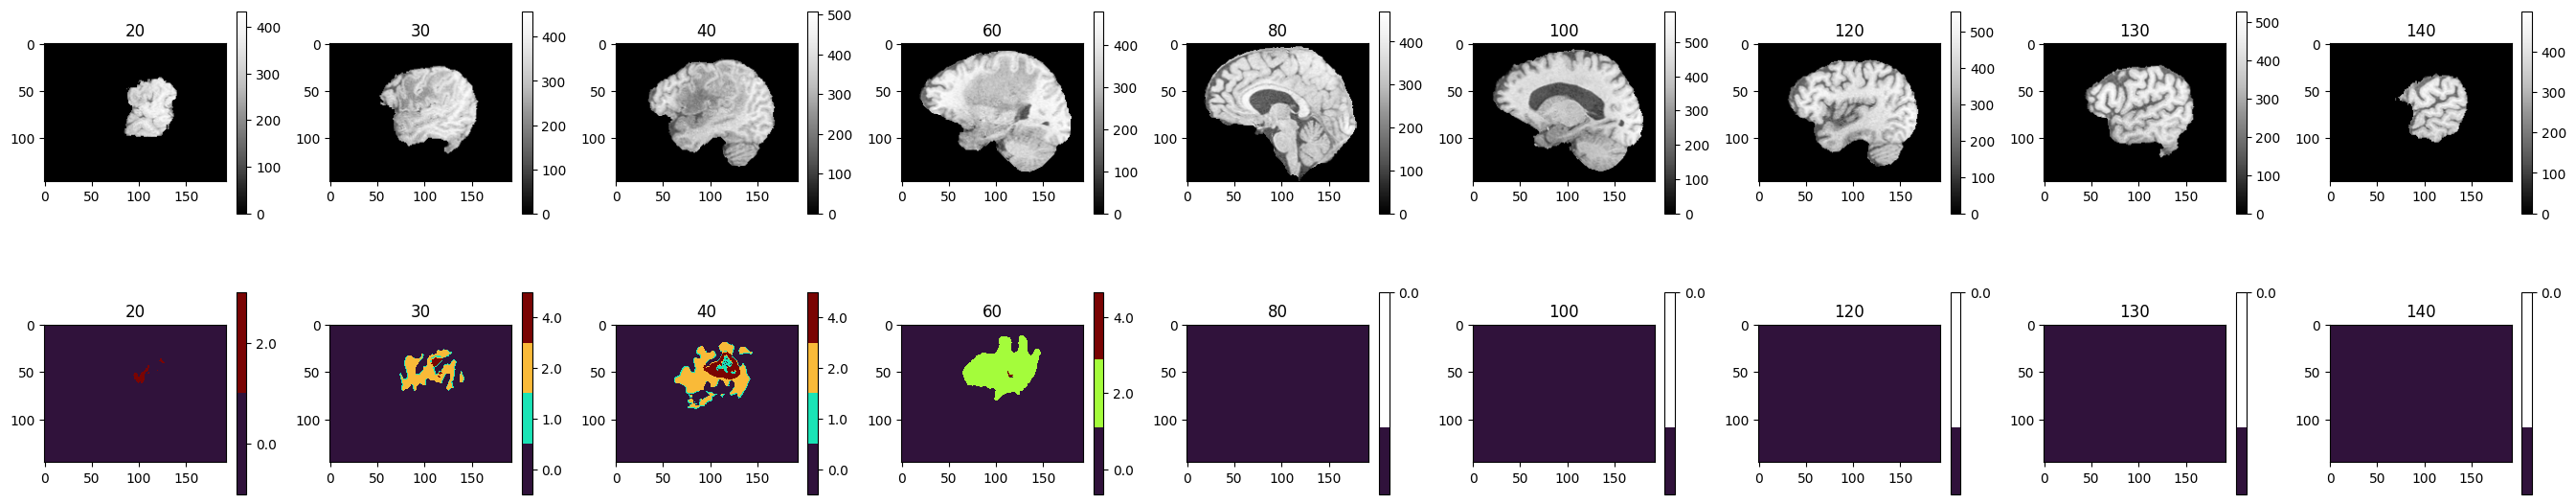

In [ ]:
subj_file = val_list[0]
struct_scan = STRUCT_SCANS[0]
data_dir = 'data/val_2d_cross'
indices = [20,30,40,60,80,100,120,130,140]

# plot struct and corresponding reduced images
fig, axs = plt.subplots(nrows=2, ncols=len(indices), figsize=(3*len(indices), 3*2))
for idx, islice in enumerate(indices):

    nifti_file = subj_file + '_' + struct_scan + '_' + str(islice) + '.nii.gz'
    nifti_path = os.path.join(data_dir, nifti_file)
    nifti = nib.load(nifti_path)
    plot_struct_img2d(img_data=np.flip( nifti.get_fdata().transpose(), axis= 0 ), fig=fig, axs=axs, row=0, col=idx, title=str(islice))

    nifti_file_segm = subj_file + '_segm_' + str(islice) + '.nii.gz'
    nifti_path_segm = os.path.join(data_dir, nifti_file_segm)
    nifti_segm = nib.load(nifti_path_segm)
    plot_segm_img2d(img_data=np.flip( nifti_segm.get_fdata().transpose(), axis= 0 ), fig=fig, axs=axs, row=1, col=idx, title=str(islice))

# show the figure
plt.tight_layout()
plt.show()

In [ ]:
type(nifti.get_fdata())

numpy.ndarray

(193, 146, 4)
T1
T2
T1GD
FLAIR
0.0 471.0035551339388 0.0 1644.9991909135133 0.0 1811.9950558058918 0.0 582.005096222274


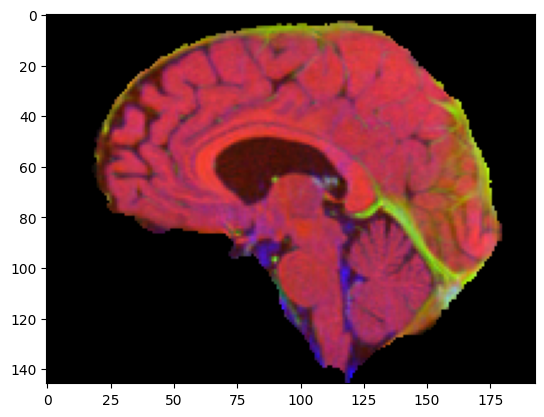

In [ ]:
# load a test file to obtain dimensions

subj_file = val_list[0]
struct_scan = STRUCT_SCANS[0]
data_dir = 'data/val_2d_cross'
islice = 80

nifti_file_segm = subj_file + '_segm_' + str(islice) + '.nii.gz'
nifti_path_segm = os.path.join(data_dir, nifti_file_segm)
nifti_segm = nib.load(nifti_path_segm)
image_segm = np.zeros( (n0,n1) )
image_segm[:,:] = nifti.get_fdata().astype('uint')[:, :]

n0 = nifti_segm.shape[0]
n1 = nifti_segm.shape[1]
image_exp = np.zeros( (n0,n1,4) )
print(image_exp.shape)

for idx, struct_scan in enumerate(STRUCT_SCANS):
    print(struct_scan)
    nifti_file = subj_file + '_' + struct_scan + '_' + str(islice) + '.nii.gz'
    nifti_path = os.path.join(data_dir, nifti_file)
    nifti = nib.load(nifti_path)
    image_exp[:,:,idx] = nifti.get_fdata()[:, :]

c0_min = np.min(image_exp[:,:,0])
c1_min = np.min(image_exp[:,:,1])
c2_min = np.min(image_exp[:,:,2])
c3_min = np.min(image_exp[:,:,3])
c0_max = np.max(image_exp[:,:,0])
c1_max = np.max(image_exp[:,:,1])
c2_max = np.max(image_exp[:,:,2])
c3_max = np.max(image_exp[:,:,3])

print(c0_min,c0_max,c1_min,c1_max,c2_min,c2_max,c3_min,c3_max)

image_exp[:,:,0] /= c0_max
image_exp[:,:,1] /= c1_max
image_exp[:,:,2] /= c2_max
image_exp[:,:,3] /= c3_max

image_exp_show = np.stack( (image_exp[:,:,0], image_exp[:,:,2], image_exp[:,:,3]), axis=2)

plt.imshow( np.flip(image_exp_show.transpose((1,0,2)), axis= 0) )

### 2.9 make a data list file

In [ ]:
train_dir = 'data/train_2d'
val_dir   = 'data/val_2d'
train_data_list_fn = train_dir + "/data_train.txt"
val_data_list_fn   = val_dir   + "/data_val.txt"

In [ ]:
# obtain data list
# obtain unique samples
train_files = os.listdir(train_dir)
train_files.sort()
train_files_unique = []
for my_file in train_files:
    train_files_unique.append(my_file.split('_')[0] + "_" + my_file.split('_')[3])

train_files_unique = list(set(train_files_unique))
train_files_unique.sort()
print(f"Number of unique training samples: {len(train_files_unique)}")

# write sample names to file
with open(train_data_list_fn, 'w') as f:
    for item in train_files_unique:
        f.write("%s\n" % item)

# obtain unique samples
val_files = os.listdir(val_dir)
val_files.sort()
val_files_unique = []
for my_file in val_files:
    val_files_unique.append(my_file.split('_')[0] + "_" + my_file.split('_')[3])
val_files_unique = list(set(val_files_unique))
val_files_unique.sort()
print(f"Number of unique validation samples: {len(val_files_unique)}")

# write sample names to file
with open(val_data_list_fn, 'w') as f:
    for item in val_files_unique:
        f.write("%s\n" % item)

In [ ]:
# peek the data_list file
!head $train_data_list_fn

### 2.10 Create Custom PyTorch Dataset


In [ ]:
# set do_reduce_label to False. Otherwise, problem with no-labeled data (ignored and causes mismatch of indices)
processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)

In [ ]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

# note that you can include more fancy data augmentation methods here
train_transform = A.Compose([
    A.Resize(width=163, height=193),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

train_dataset = CustomMRIDataset(train_dir, data_list_fn=train_data_list_fn, processor=processor, transform=train_transform)
val_dataset   = CustomMRIDataset(val_dir, data_list_fn=val_data_list_fn,   processor=processor, transform=train_transform)


In [ ]:
# peek at the dataset

inputs = val_dataset[110]
for k,v in inputs.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

print(len(val_dataset))
print(inputs["class_labels"])
print(inputs)

In [ ]:
## visualize input image
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = ( inputs['pixel_values'].numpy() * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [ ]:
## visualize input maks
mask_idx = 1
visual_mask = ( inputs['mask_labels'][mask_idx].bool().numpy() * 255 ).astype(np.uint8)
Image.fromarray(visual_mask)

In [ ]:
# setup data loader
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

In [ ]:
batch["pixel_values"][0]

### 2.11 Verify data (!!)

As always, it's very important to check whether the data which we'll feed to the model makes sense. Let's do some sanity checks.

One of them is denormalizing the pixel values to see whether we still get an image that makes sense.

In [ ]:
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

batch_index = 0

unnormalized_image = (batch["pixel_values"][batch_index].numpy() * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [ ]:
id2label = {}
id2label[0] = 'else'
id2label[1] = 'NCR'
id2label[2] = 'ED'
id2label[4] = 'ET'
id2label

In [ ]:
batch["mask_labels"][batch_index]

In [ ]:
print("Visualizing mask for:", id2label[batch["class_labels"][batch_index][0].item()])

visual_mask = (batch["mask_labels"][batch_index][0].bool().numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

In [ ]:
print("Visualizing mask for:", id2label[batch["class_labels"][batch_index][1].item()])

visual_mask = (batch["mask_labels"][batch_index][1].bool().numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

*In* this case, there are many class labels it seems.

In [ ]:
batch["class_labels"][batch_index]

In [ ]:
for idx in range( batch["class_labels"][batch_index].shape[0]):
    label_id = batch["class_labels"][batch_index][idx].item()
    print("Labels in image:", id2label[label_id])

In [ ]:
batch["class_labels"][batch_index][0].item()

In [ ]:
id2label[batch["class_labels"][batch_index][0].item()]
